<a href="https://colab.research.google.com/github/binodsth2/Blood_Sugar_Detection_using_machine_Learning/blob/main/Diabetes_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import learning_curve, validation_curve
import joblib

In [3]:
# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/Machine_Learning/diabetes.csv')

In [4]:
# Display basic info
print("="*80)
print("DIABETES PREDICTION AND ANALYSIS SYSTEM")
print("="*80)

print("\n1. DATASET INFORMATION:")
print("-"*40)
df.info()

print("\n2. DATASET SHAPE:")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n3. COLUMN NAMES:")
print(df.columns.tolist())

print("\n4. MISSING VALUES:")
print(df.isnull().sum())

print("\n5. BASIC STATISTICS:")
print(df.describe())

DIABETES PREDICTION AND ANALYSIS SYSTEM

1. DATASET INFORMATION:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13

In [5]:
# Check for your target variable - adjust name if different
target_column = 'Diabetes_012'  # Change if your target has different name
print(f"\n6. TARGET VARIABLE DISTRIBUTION ({target_column}):")
target_counts = df[target_column].value_counts()
print(target_counts)


6. TARGET VARIABLE DISTRIBUTION (Diabetes_012):
Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64


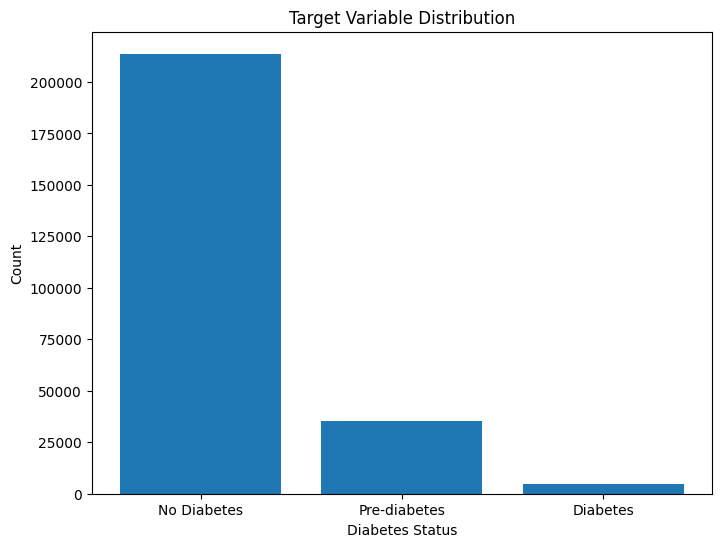

In [6]:
# Visualize target distribution
plt.figure(figsize=(8, 6))
plt.bar(['No Diabetes', 'Pre-diabetes', 'Diabetes'], target_counts.values)
plt.title('Target Variable Distribution')
plt.xlabel('Diabetes Status')
plt.ylabel('Count')
plt.show()

In [7]:
# Check for any missing values
if df.isnull().sum().any():
    print("\nMissing values detected. Handling missing values...")
    df = df.fillna(df.mean())
    print("Missing values filled with column means.")

In [8]:
# Prepare features and target
x = df.drop(target_column, axis=1)
y = df[target_column]

print(f"\n7. FEATURE MATRIX SHAPE: {x.shape}")
print(f"TARGET VECTOR SHAPE: {y.shape}")



7. FEATURE MATRIX SHAPE: (253680, 21)
TARGET VECTOR SHAPE: (253680,)


In [9]:
# Check if your scatter plot columns exist
print("\n8. CHECKING FOR PLOTTING COLUMNS:")
available_columns = x.columns.tolist()
print(f"Available columns: {available_columns[:10]}...")  # Show first 10


8. CHECKING FOR PLOTTING COLUMNS:
Available columns: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies']...


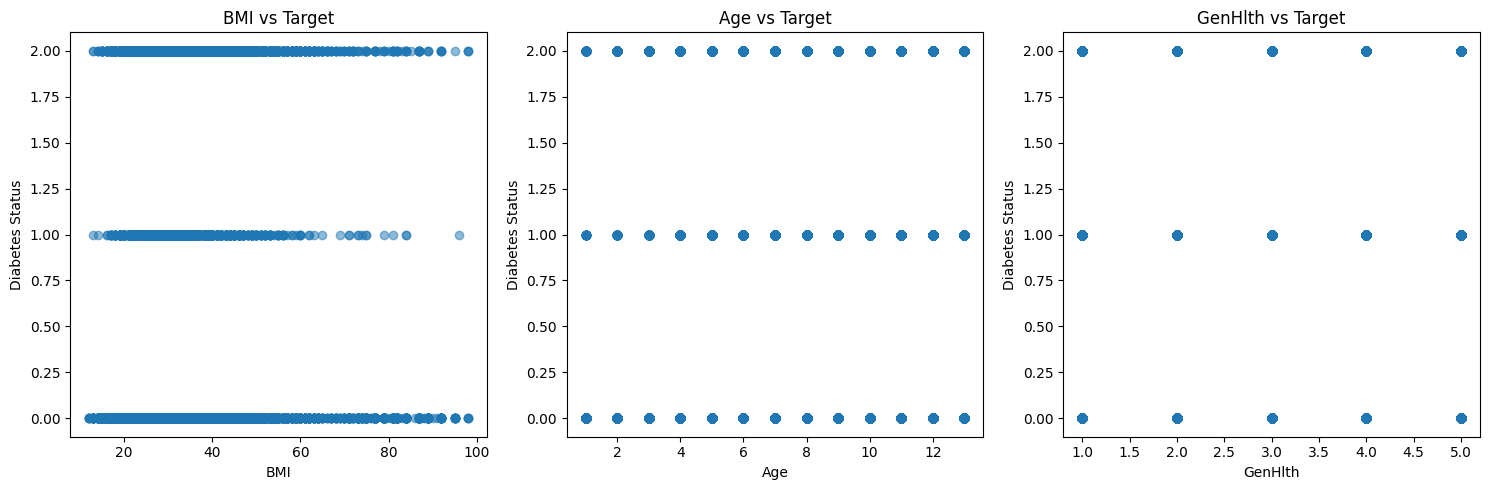

In [10]:
# Use available columns for scatter plot
scatter_cols = []
for col in ['BMI', 'Age', 'GenHlth']:  # Changed from your original selection
    if col in x.columns:
        scatter_cols.append(col)

if scatter_cols:
    # Create figure for scatter plots
    fig, axes = plt.subplots(1, len(scatter_cols), figsize=(15, 5))
    if len(scatter_cols) == 1:
        axes = [axes]

    for idx, col in enumerate(scatter_cols):
        axes[idx].scatter(x[col], y, alpha=0.5)
        axes[idx].set_title(f'{col} vs Target')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Diabetes Status')

    plt.tight_layout()
    plt.show()


9. FEATURE CORRELATION HEATMAP:


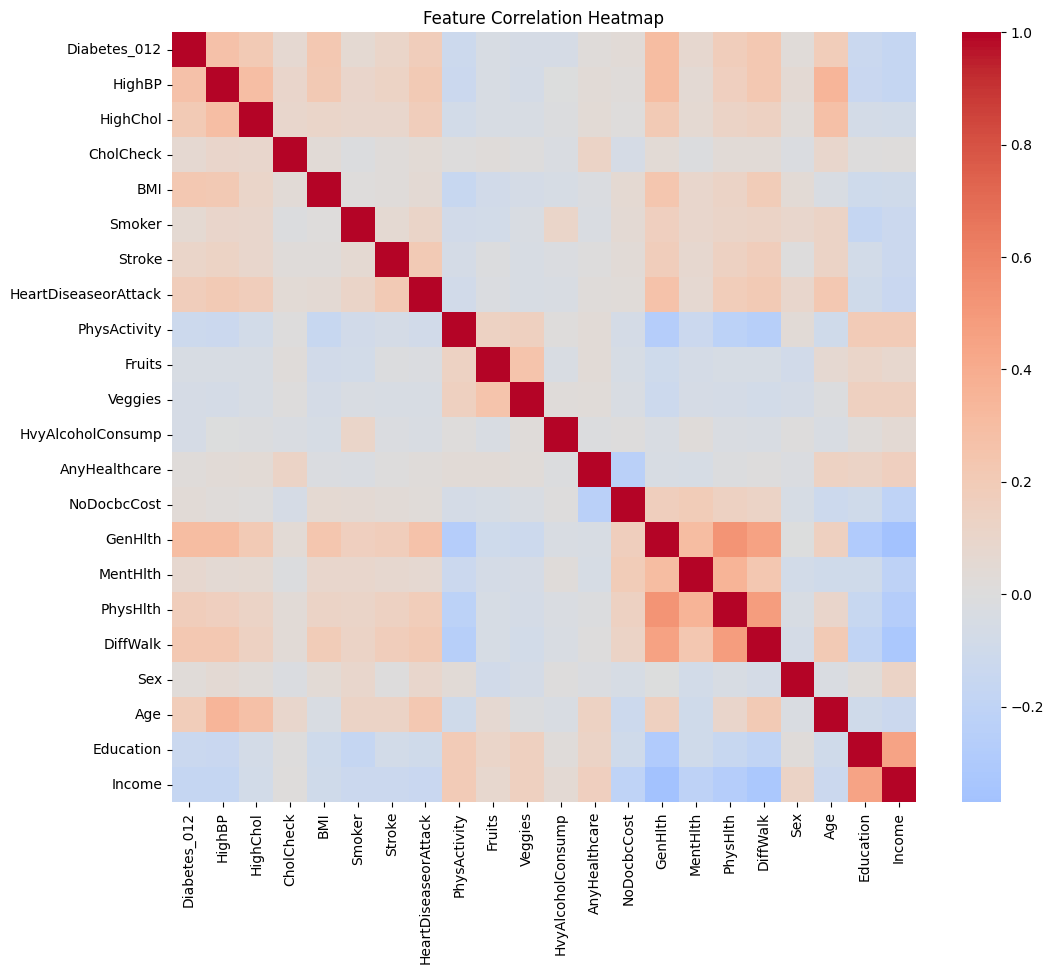

In [11]:
# Correlation heatmap
print("\n9. FEATURE CORRELATION HEATMAP:")
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

In [12]:
# Top correlations with target
if target_column in correlation_matrix.columns:
    target_correlations = correlation_matrix[target_column].abs().sort_values(ascending=False)
    print("\nTop 10 features correlated with target:")
    print(target_correlations.head(11)[1:])  # Skip the target itself


Top 10 features correlated with target:
GenHlth                 0.302587
HighBP                  0.271596
BMI                     0.224379
DiffWalk                0.224239
HighChol                0.209085
Age                     0.185026
HeartDiseaseorAttack    0.180272
PhysHlth                0.176287
Income                  0.171483
Education               0.130517
Name: Diabetes_012, dtype: float64


In [13]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
print(f"\n10. DATA SPLIT:")
print(f"Training set: {x_train.shape[0]} samples")
print(f"Testing set: {x_test.shape[0]} samples")


10. DATA SPLIT:
Training set: 202944 samples
Testing set: 50736 samples


In [14]:
# Scaling features
print("\n11. SCALING FEATURES...")
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


11. SCALING FEATURES...


In [15]:
# Display first few rows of scaled data
print("First 5 rows of scaled training data:")
print(pd.DataFrame(x_train_scaled, columns=x.columns).head())

First 5 rows of scaled training data:
     HighBP  HighChol  CholCheck       BMI    Smoker    Stroke  \
0  1.153250 -0.858426   0.197488 -0.512552 -0.893675 -0.205655   
1 -0.867115 -0.858426   0.197488  1.301115  1.118975 -0.205655   
2  1.153250  1.164923   0.197488  0.998837 -0.893675 -0.205655   
3 -0.867115 -0.858426   0.197488 -0.210274 -0.893675 -0.205655   
4 -0.867115 -0.858426   0.197488 -0.059135  1.118975 -0.205655   

   HeartDiseaseorAttack  PhysActivity    Fruits   Veggies  ...  AnyHealthcare  \
0              -0.32264      0.567078  0.759080  0.481953  ...       0.227395   
1              -0.32264      0.567078  0.759080  0.481953  ...       0.227395   
2              -0.32264      0.567078  0.759080 -2.074891  ...       0.227395   
3              -0.32264      0.567078 -1.317384 -2.074891  ...       0.227395   
4              -0.32264      0.567078 -1.317384 -2.074891  ...       0.227395   

   NoDocbcCost   GenHlth  MentHlth  PhysHlth  DiffWalk       Sex       Age  \


In [16]:

# Label encoding for target
print("\n12. ENCODING TARGET VARIABLE...")
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Target encoding mapping:")
for i, label in enumerate(le.classes_):
    print(f"  {i}: {label}")


12. ENCODING TARGET VARIABLE...
Target encoding mapping:
  0: 0.0
  1: 1.0
  2: 2.0


In [17]:
# Initialize models with improved parameters
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    #'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Bagging Classifier': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
}

print("\n13. TRAINING AND EVALUATING MODELS:")
print("-"*80)

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(x_train_scaled, y_train_encoded)

    # Make predictions
    y_pred = model.predict(x_test_scaled)
    y_pred_proba = model.predict_proba(x_test_scaled) if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")


13. TRAINING AND EVALUATING MODELS:
--------------------------------------------------------------------------------

Training Logistic Regression...
  Accuracy: 0.8455
  F1-Score: 0.8069
  Precision: 0.7977
  Recall: 0.8455

Training Random Forest...
  Accuracy: 0.8479
  F1-Score: 0.7975
  Precision: 0.8022
  Recall: 0.8479

Training XGBoost...
  Accuracy: 0.8496
  F1-Score: 0.8115
  Precision: 0.8053
  Recall: 0.8496

Training K-Nearest Neighbors...
  Accuracy: 0.8325
  F1-Score: 0.8025
  Precision: 0.7874
  Recall: 0.8325

Training Gradient Boosting...
  Accuracy: 0.8489
  F1-Score: 0.8110
  Precision: 0.8046
  Recall: 0.8489

Training AdaBoost...
  Accuracy: 0.8469
  F1-Score: 0.8124
  Precision: 0.8021
  Recall: 0.8469

Training Bagging Classifier...
  Accuracy: 0.8364
  F1-Score: 0.8086
  Precision: 0.7937
  Recall: 0.8364


In [18]:
# Create comparison DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results]
}).sort_values('Accuracy', ascending=False)

print("\n14. MODEL PERFORMANCE COMPARISON:")
print("-"*80)
print(results_df.to_string(index=False))


14. MODEL PERFORMANCE COMPARISON:
--------------------------------------------------------------------------------
              Model  Accuracy  F1-Score  Precision   Recall
            XGBoost  0.849555  0.811536   0.805265 0.849555
  Gradient Boosting  0.848944  0.810958   0.804593 0.848944
      Random Forest  0.847938  0.797505   0.802152 0.847938
           AdaBoost  0.846894  0.812394   0.802127 0.846894
Logistic Regression  0.845475  0.806922   0.797686 0.845475
 Bagging Classifier  0.836428  0.808584   0.793691 0.836428
K-Nearest Neighbors  0.832506  0.802527   0.787446 0.832506


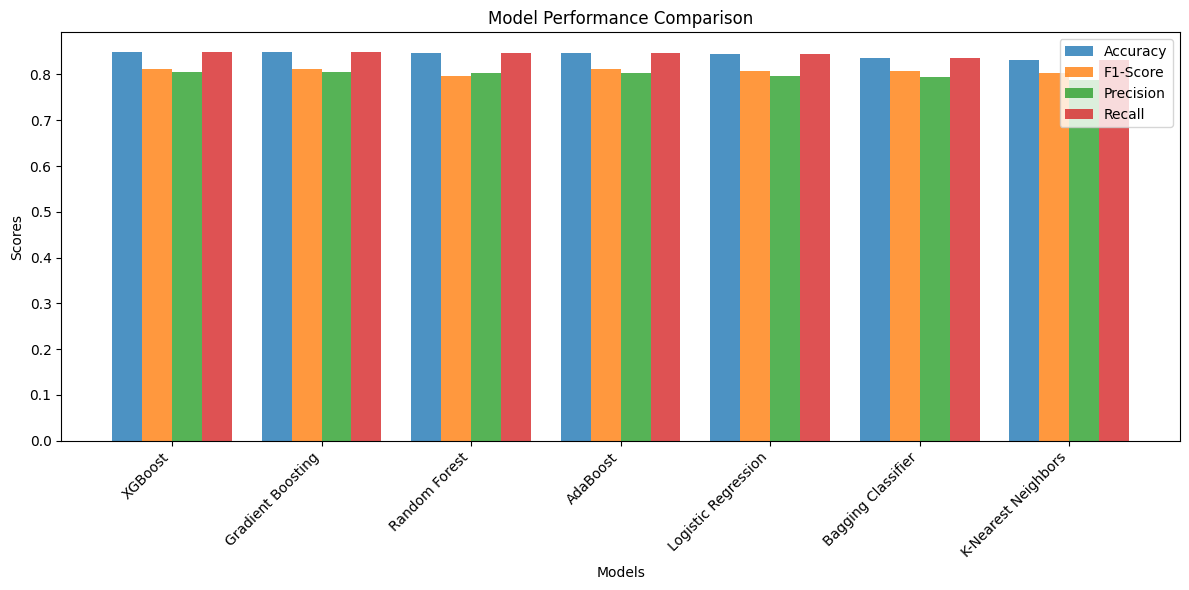

In [19]:
# Visualize model comparison
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(results_df))
width = 0.2

plt.bar(x_pos - 1.5*width, results_df['Accuracy'], width, label='Accuracy', alpha=0.8)
plt.bar(x_pos - 0.5*width, results_df['F1-Score'], width, label='F1-Score', alpha=0.8)
plt.bar(x_pos + 0.5*width, results_df['Precision'], width, label='Precision', alpha=0.8)
plt.bar(x_pos + 1.5*width, results_df['Recall'], width, label='Recall', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x_pos, results_df['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Select best model
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\n15. BEST MODEL: {best_model_name}")
print(f"    Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")


15. BEST MODEL: XGBoost
    Accuracy: 0.8496


In [21]:
# Detailed evaluation of best model
print(f"\n16. DETAILED EVALUATION OF {best_model_name}:")
print("-"*80)

y_pred_best = results[best_model_name]['predictions']

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_best,
                           target_names=['No Diabetes', 'Pre-diabetes', 'Diabetes']))

print("Confusion Matrix:")
cm = confusion_matrix(y_test_encoded, y_pred_best)
print(cm)


16. DETAILED EVALUATION OF XGBoost:
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.86      0.98      0.92     42741
Pre-diabetes       0.00      0.00      0.00       926
    Diabetes       0.56      0.19      0.28      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.81      0.85      0.81     50736

Confusion Matrix:
[[41790     0   951]
 [  831     0    95]
 [ 5756     0  1313]]


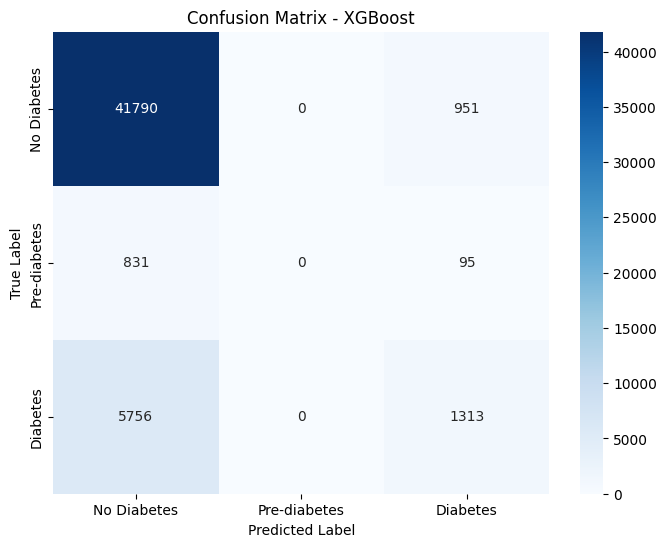

In [22]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Pre-diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Pre-diabetes', 'Diabetes'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


17. FEATURE IMPORTANCE:

Top 10 Important Features:
                 feature  importance
0                 HighBP    0.508323
13               GenHlth    0.135262
1               HighChol    0.077208
10     HvyAlcoholConsump    0.036811
2              CholCheck    0.035256
18                   Age    0.029686
3                    BMI    0.028349
6   HeartDiseaseorAttack    0.023719
16              DiffWalk    0.018165
17                   Sex    0.016316


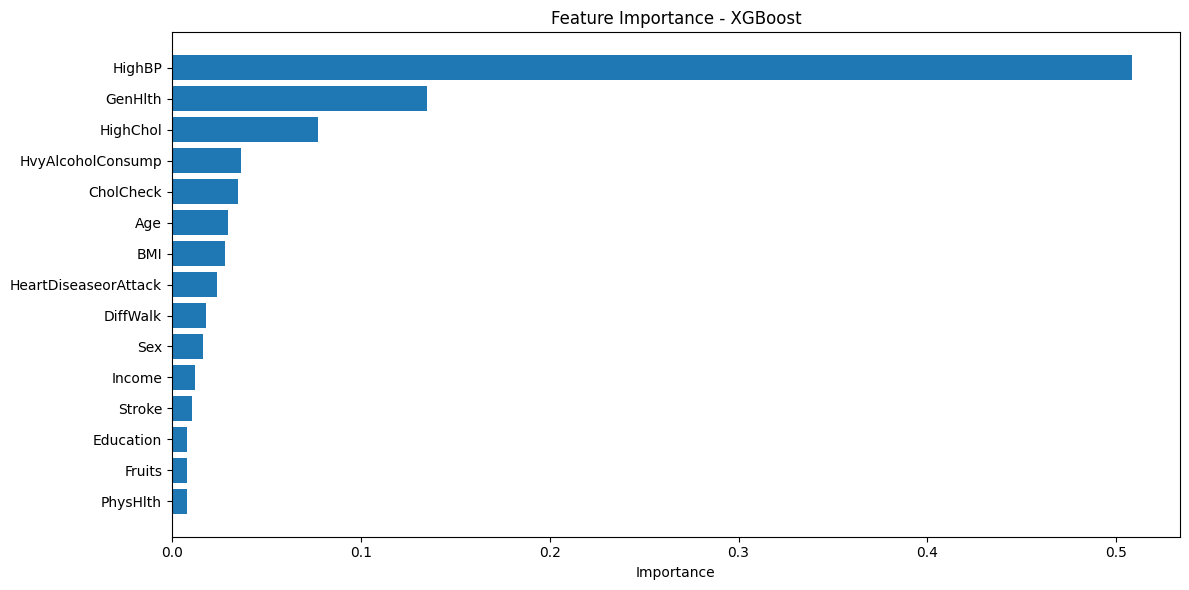

In [23]:
# Feature importance visualization
if hasattr(best_model, 'feature_importances_'):
    print("\n17. FEATURE IMPORTANCE:")
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': x.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Important Features:")
    print(feature_importance_df.head(10))

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    top_features = feature_importance_df.head(15)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


21. COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS:
--------------------------------------------------------------------------------

Top 15 Most Important Features:
             Feature  Importance  Percentage
              HighBP    0.508323   50.832264
             GenHlth    0.135262   13.526215
            HighChol    0.077208    7.720838
   HvyAlcoholConsump    0.036811    3.681089
           CholCheck    0.035256    3.525568
                 Age    0.029686    2.968619
                 BMI    0.028349    2.834868
HeartDiseaseorAttack    0.023719    2.371912
            DiffWalk    0.018165    1.816476
                 Sex    0.016316    1.631550
              Income    0.012331    1.233103
              Stroke    0.010746    1.074572
           Education    0.007991    0.799080
              Fruits    0.007878    0.787792
            PhysHlth    0.007809    0.780895

Top 5 Features Account for 79.29% of Model Decision
Top 10 Features Account for 90.91% of Model Decision

Features ne

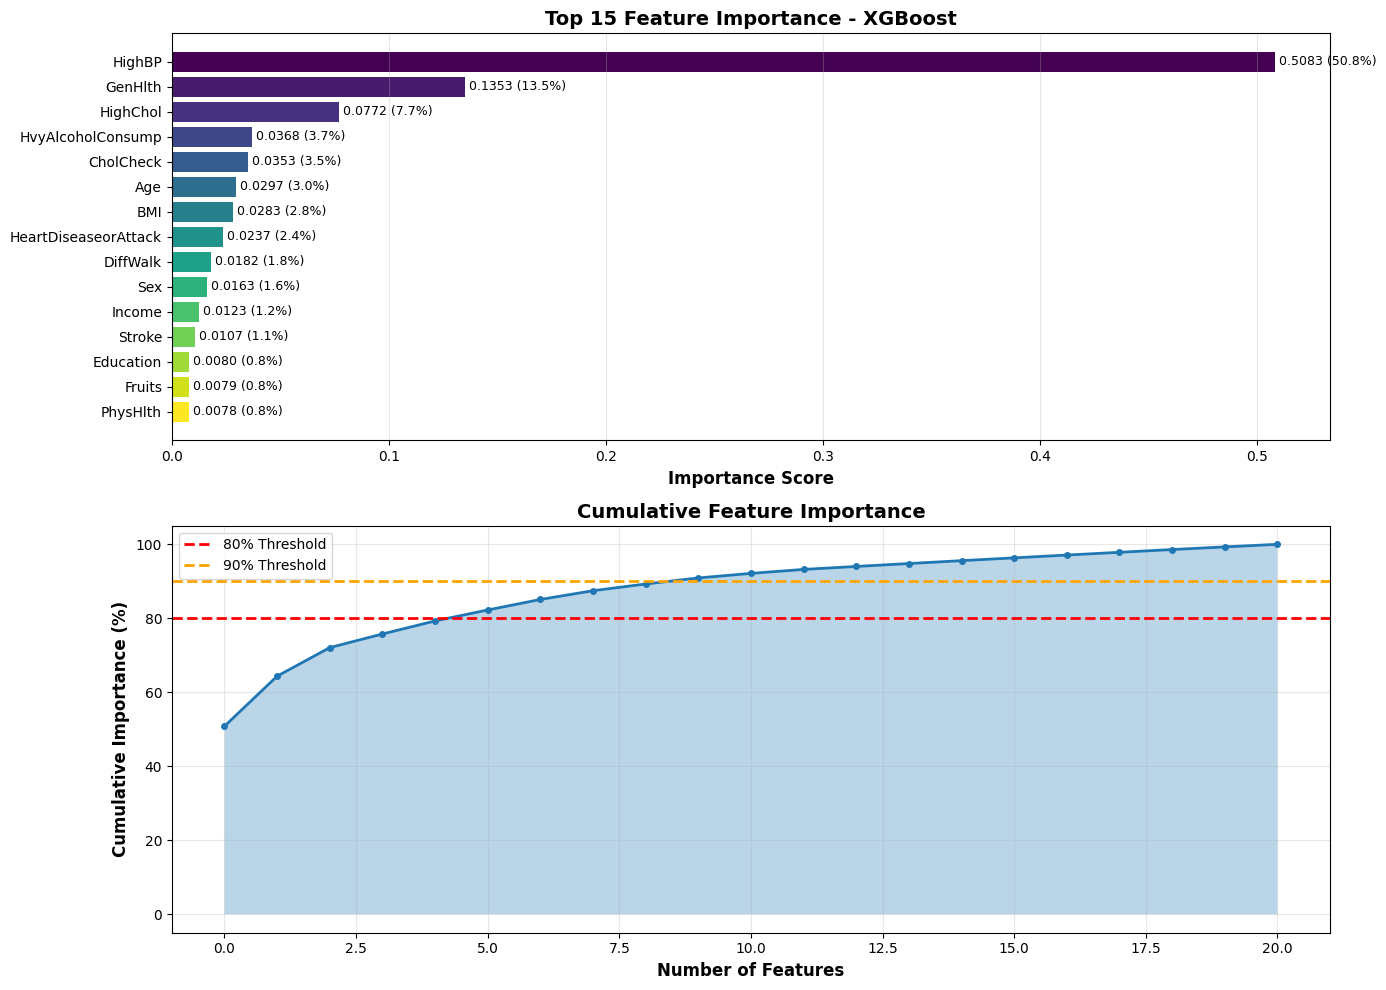

In [24]:
# Enhanced Feature Importance Visualization
if hasattr(best_model, 'feature_importances_'):
    print("\n21. COMPREHENSIVE FEATURE IMPORTANCE ANALYSIS:")
    print("-"*80)

    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': x.columns,
        'Importance': importances,
        'Percentage': (importances / importances.sum() * 100)
    }).sort_values('Importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance_df.head(15).to_string(index=False))

    # Statistics
    print(f"\nTop 5 Features Account for {feature_importance_df.head(5)['Percentage'].sum():.2f}% of Model Decision")
    print(f"Top 10 Features Account for {feature_importance_df.head(10)['Percentage'].sum():.2f}% of Model Decision")

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Plot 1: Top 15 Features
    top_15 = feature_importance_df.head(15)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_15)))

    bars1 = axes[0].barh(range(len(top_15)), top_15['Importance'], color=colors)
    axes[0].set_yticks(range(len(top_15)))
    axes[0].set_yticklabels(top_15['Feature'])
    axes[0].set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Top 15 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars1, top_15['Importance'])):
        axes[0].text(val, bar.get_y() + bar.get_height()/2,
                    f' {val:.4f} ({top_15.iloc[i]["Percentage"]:.1f}%)',
                    va='center', fontsize=9)

    axes[0].grid(axis='x', alpha=0.3)

    # Plot 2: Cumulative Importance
    cumsum = feature_importance_df['Percentage'].cumsum()
    axes[1].plot(range(len(feature_importance_df)), cumsum.values, marker='o', linewidth=2, markersize=4)
    axes[1].axhline(y=80, color='r', linestyle='--', label='80% Threshold', linewidth=2)
    axes[1].axhline(y=90, color='orange', linestyle='--', label='90% Threshold', linewidth=2)
    axes[1].fill_between(range(len(feature_importance_df)), cumsum.values, alpha=0.3)
    axes[1].set_xlabel('Number of Features', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    # Find how many features needed for 80% and 90%
    features_80 = (cumsum <= 80).sum() + 1
    features_90 = (cumsum <= 90).sum() + 1

    print(f"\nFeatures needed to explain:")
    print(f"  80% of model decisions: {features_80} features")
    print(f"  90% of model decisions: {features_90} features")

    plt.tight_layout()
    plt.show()


In [25]:
# Save the best model and scaler
print("\n18. SAVING MODEL AND PREPROCESSORS...")
joblib.dump(best_model, 'best_diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("Model saved as 'best_diabetes_model.pkl'")
print("Scaler saved as 'scaler.pkl'")
print("Label encoder saved as 'label_encoder.pkl'")


18. SAVING MODEL AND PREPROCESSORS...
Model saved as 'best_diabetes_model.pkl'
Scaler saved as 'scaler.pkl'
Label encoder saved as 'label_encoder.pkl'


In [26]:
# Create prediction function
def predict_diabetes_risk(new_data, model=best_model, scaler=scaler, label_encoder=le):
    """
    Predict diabetes risk for new patient data

    Parameters:
    new_data: dict or pandas Series with feature values
    model: trained model
    scaler: fitted scaler
    label_encoder: fitted label encoder

    Returns:
    Dictionary with prediction and probabilities
    """
    # Convert to DataFrame
    if isinstance(new_data, dict):
        new_df = pd.DataFrame([new_data])
    else:
        new_df = pd.DataFrame([new_data])

    # Ensure all columns are present
    for col in x.columns:
        if col not in new_df.columns:
            new_df[col] = x[col].median()  # Fill missing with median

    # Reorder columns
    new_df = new_df[x.columns]

    # Scale the data
    new_scaled = scaler.transform(new_df)

    # Make prediction
    prediction_encoded = model.predict(new_scaled)[0]
    prediction = label_encoder.inverse_transform([prediction_encoded])[0]

    # Get probabilities if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(new_scaled)[0]
        prob_dict = {}
        for i, class_name in enumerate(label_encoder.classes_):
            prob_dict[class_name] = f"{probabilities[i]:.2%}"
    else:
        prob_dict = None

    # Create result dictionary
    result = {
        'prediction': prediction,
        'prediction_label': ['No Diabetes', 'Pre-diabetes', 'Diabetes'][prediction_encoded],
        'risk_level': ['Low', 'Medium', 'High'][prediction_encoded]
    }

    if prob_dict:
        result['probabilities'] = prob_dict

    return result

In [27]:
# Test prediction with example data
print("\n19. TESTING PREDICTION FUNCTION:")
print("-"*80)


19. TESTING PREDICTION FUNCTION:
--------------------------------------------------------------------------------


In [28]:
# Create example patient data based on your dataset columns
example_patient = {}
for col in x.columns:
    # Use median values for continuous features, mode for binary
    if df[col].nunique() == 2:  # Binary feature
        example_patient[col] = df[col].mode()[0]
    else:
        example_patient[col] = df[col].median()

In [29]:
# Make prediction
try:
    prediction_result = predict_diabetes_risk(example_patient)
    print(f"Example Prediction for Patient with Median Values:")
    print(f"  Prediction: {prediction_result['prediction_label']}")
    print(f"  Risk Level: {prediction_result['risk_level']}")
    if 'probabilities' in prediction_result:
        print(f"  Probabilities:")
        for risk, prob in prediction_result['probabilities'].items():
            print(f"    {risk}: {prob}")
except Exception as e:
    print(f"Prediction error: {e}")

Example Prediction for Patient with Median Values:
  Prediction: No Diabetes
  Risk Level: Low
  Probabilities:
    0.0: 96.96%
    1.0: 0.72%
    2.0: 2.32%


In [30]:
# Create comprehensive patient analysis function
def analyze_patient_health(patient_data):
    """
    Comprehensive health analysis for a patient
    """
    # Make prediction
    prediction = predict_diabetes_risk(patient_data)

    print("\n" + "="*80)
    print("COMPREHENSIVE PATIENT HEALTH ANALYSIS")
    print("="*80)

    print(f"\nDiabetes Risk Assessment:")
    print(f"  Risk Level: {prediction['risk_level']}")
    print(f"  Prediction: {prediction['prediction_label']}")

    if 'probabilities' in prediction:
        print(f"  Risk Probabilities:")
        for risk, prob in prediction['probabilities'].items():
            print(f"    {risk}: {prob}")

    # Identify key risk factors
    print(f"\nKey Risk Factors Detected:")

    risk_factors = []

    # Define risk thresholds
    if 'HighBP' in patient_data and patient_data.get('HighBP', 0) == 1:
        risk_factors.append("High Blood Pressure")
    if 'HighChol' in patient_data and patient_data.get('HighChol', 0) == 1:
        risk_factors.append("High Cholesterol")
    if 'BMI' in patient_data:
        bmi = patient_data['BMI']
        if bmi >= 30:
            risk_factors.append(f"Obesity (BMI: {bmi:.1f})")
        elif bmi >= 25:
            risk_factors.append(f"Overweight (BMI: {bmi:.1f})")
    if 'Smoker' in patient_data and patient_data.get('Smoker', 0) == 1:
        risk_factors.append("Smoking")
    if 'PhysActivity' in patient_data and patient_data.get('PhysActivity', 0) == 0:
        risk_factors.append("No Physical Activity")
    if 'GenHlth' in patient_data and patient_data.get('GenHlth', 0) >= 4:
        risk_factors.append("Poor General Health")

    if risk_factors:
        for i, factor in enumerate(risk_factors, 1):
            print(f"  {i}. {factor}")
    else:
        print("  No major risk factors detected")

    # Recommendations
    print(f"\nPersonalized Recommendations:")

    recommendations = []

    if 'BMI' in patient_data and patient_data.get('BMI', 0) > 25:
        recommendations.append("Consider weight management through balanced diet and regular exercise")

    if 'PhysActivity' in patient_data and patient_data.get('PhysActivity', 0) == 0:
        recommendations.append("Incorporate at least 150 minutes of moderate exercise weekly")

    if ('HighBP' in patient_data and patient_data.get('HighBP', 0) == 1) or \
       ('HighChol' in patient_data and patient_data.get('HighChol', 0) == 1):
        recommendations.append("Regular monitoring of blood pressure and cholesterol levels")

    if 'Smoker' in patient_data and patient_data.get('Smoker', 0) == 1:
        recommendations.append("Consider smoking cessation support programs")

    if 'Fruits' in patient_data and patient_data.get('Fruits', 0) == 0:
        recommendations.append("Increase fruit consumption for better nutrition")

    if 'Veggies' in patient_data and patient_data.get('Veggies', 0) == 0:
        recommendations.append("Increase vegetable intake for essential nutrients")

    if recommendations:
        for i, rec in enumerate(recommendations, 1):
            print(f"  {i}. {rec}")
    else:
        print("  Maintain current healthy lifestyle habits")

    # Next steps based on risk
    risk_level = prediction['risk_level']
    print(f"\nSuggested Next Steps:")

    if risk_level == 'Low':
        print("  • Annual comprehensive health checkup")
        print("  • Continue healthy lifestyle maintenance")
        print("  • Regular self-monitoring of key health indicators")
    elif risk_level == 'Medium':
        print("  • Bi-annual health monitoring (every 6 months)")
        print("  • Consider nutritional counseling")
        print("  • Regular exercise program with professional guidance")
        print("  • Monitor blood glucose levels periodically")
    else:  # High risk
        print("  • Immediate consultation with healthcare provider")
        print("  • Regular blood glucose monitoring (weekly or as advised)")
        print("  • Comprehensive diabetes management plan")
        print("  • Regular follow-ups with specialist")
        print("  • Consider medication if lifestyle changes are insufficient")

    return prediction

print("\n20. SYSTEM READY FOR PATIENT ANALYSIS")
print("="*80)


20. SYSTEM READY FOR PATIENT ANALYSIS


In [31]:
# Load saved model function
def load_saved_model():
    """Load saved model and preprocessors"""
    try:
        model = joblib.load('best_diabetes_model.pkl')
        scaler = joblib.load('scaler.pkl')
        le = joblib.load('label_encoder.pkl')
        print("Model and preprocessors loaded successfully!")
        return model, scaler, le
    except:
        print("Saved files not found. Using current session model.")
        return best_model, scaler, le

print("\nTo analyze a new patient, use:")
print("analyze_patient_health(patient_data_dict)")
print("\nExample patient data format:")
print("""
{
    'HighBP': 1,
    'HighChol': 1,
    'CholCheck': 1,
    'BMI': 35,
    'Smoker': 0,
    'Stroke': 0,
    'HeartDiseaseorAttack': 0,
    'PhysActivity': 0,
    'Fruits': 0,
    'Veggies': 1,
    'HvyAlcoholConsump': 0,
    'AnyHealthcare': 1,
    'NoDocbcCost': 0,
    'GenHlth': 4,
    'MentHlth': 10,
    'PhysHlth': 15,
    'DiffWalk': 1,
    'Sex': 0,
    'Age': 9,
    'Education': 4,
    'Income': 3
}
""")

print("\n" + "="*80)
print("ANALYSIS COMPLETE - MODEL READY FOR USE")
print("="*80)


To analyze a new patient, use:
analyze_patient_health(patient_data_dict)

Example patient data format:

{
    'HighBP': 1,
    'HighChol': 1,
    'CholCheck': 1,
    'BMI': 35,
    'Smoker': 0,
    'Stroke': 0,
    'HeartDiseaseorAttack': 0,
    'PhysActivity': 0,
    'Fruits': 0,
    'Veggies': 1,
    'HvyAlcoholConsump': 0,
    'AnyHealthcare': 1,
    'NoDocbcCost': 0,
    'GenHlth': 4,
    'MentHlth': 10,
    'PhysHlth': 15,
    'DiffWalk': 1,
    'Sex': 0,
    'Age': 9,
    'Education': 4,
    'Income': 3
}


ANALYSIS COMPLETE - MODEL READY FOR USE


Comprehensive Model Performance Discussion and Analysis 3. Model Performance


In [38]:
print("\n" + "="*80)
print("22. DETAILED MODEL PERFORMANCE ANALYSIS & DISCUSSION")
print("="*80)

print("\n" + "-"*80)
print("PERFORMANCE METRICS EXPLANATION")
print("-"*80)

print("""
Key Performance Metrics Explained:

1. ACCURACY:
   - What % of predictions were correct overall
   - Formula: (TP + TN) / (TP + TN + FP + FN)
   - Limitation: Can be misleading with imbalanced datasets
   - Use: General model quality indicator

2. PRECISION:
   - Of all positive predictions, how many were actually correct
   - Formula: TP / (TP + FP)
   - Importance: Critical when False Positives are costly
   - In Diabetes: Minimizes unnecessary alarms for healthy patients

3. RECALL (Sensitivity):
   - Of all actual positives, how many did we catch
   - Formula: TP / (TP + FN)
   - Importance: Critical when False Negatives are costly
   - In Diabetes: Essential to catch all at-risk patients

4. F1-SCORE:
   - Harmonic mean of Precision and Recall
   - Formula: 2 * (Precision * Recall) / (Precision + Recall)
   - Best for: Imbalanced datasets where we need balance between precision and recall
   - Range: 0 to 1 (higher is better)

5. SPECIFICITY:
   - Of all actual negatives, how many did we correctly identify
   - Formula: TN / (TN + FP)
   - Importance: Identifies how well model detects non-diabetics
""")

# Detailed Metrics Analysis
print("\n" + "-"*80)
print("MODEL PERFORMANCE BREAKDOWN")
print("-"*80)

best_model_result = results[best_model_name]
y_pred_best = best_model_result['predictions']

# The confusion matrix for multi-class will be 3x3
cm_best = confusion_matrix(y_test_encoded, y_pred_best)

# Extract tp, fn, fp, tn for the 'Diabetes' class (class 2) as the positive class
tp_c2 = cm_best[2, 2]
fn_c2 = cm_best[2, 0] + cm_best[2, 1]  # Actual Diabetes, predicted No Diabetes or Pre-diabetes
fp_c2 = cm_best[0, 2] + cm_best[1, 2]  # Actual No Diabetes or Pre-diabetes, predicted Diabetes
tn_c2 = cm_best[0, 0] + cm_best[0, 1] + cm_best[1, 0] + cm_best[1, 1] # Actual Not Diabetes, predicted Not Diabetes

print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {best_model_result['accuracy']:.4f} ({best_model_result['accuracy']*100:.2f}%)")
print(f"Precision: {best_model_result['precision']:.4f} ({best_model_result['precision']*100:.2f}%)")
print(f"Recall: {best_model_result['recall']:.4f} ({best_model_result['recall']*100:.2f}%)")
print(f"F1-Score: {best_model_result['f1']:.4f}")

print("\n" + "-"*80)
print("CONFUSION MATRIX ANALYSIS")
print("-"*80)

print("\nConfusion Matrix:")
print(f"{'':25} Predicted No | Predicted Pre | Predicted Yes")
print(f"{'Actual No Diabetes':25} {cm_best[0,0]:>11} | {cm_best[0,1]:>13} | {cm_best[0,2]:>13}")
print(f"{'Actual Pre-Diabetes':25} {cm_best[1,0]:>11} | {cm_best[1,1]:>13} | {cm_best[1,2]:>13}")
print(f"{'Actual Diabetes':25} {cm_best[2,0]:>11} | {cm_best[2,1]:>13} | {cm_best[2,2]:>13}")

# Per-class metrics
print("\n" + "-"*80)
print("CLASS-WISE PERFORMANCE")
print("-"*80)

class_report = classification_report(y_test_encoded, y_pred_best,
                                      target_names=['No Diabetes', 'Pre-diabetes', 'Diabetes'],
                                      output_dict=True)

print("\nDetailed Class Breakdown:")
for class_label in ['No Diabetes', 'Pre-diabetes', 'Diabetes']:
    metrics = class_report[class_label]
    print(f"\n{class_label}:")
    print(f"  Precision: {metrics['precision']:.4f} - Reliability when predicting this class")
    print(f"  Recall: {metrics['recall']:.4f} - Coverage of actual cases in this class")
    print(f"  F1-Score: {metrics['f1-score']:.4f} - Balanced score")
    print(f"  Support: {int(metrics['support'])} - Number of samples in this class")

# Model Comparison Summary
print("\n" + "-"*80)
print("COMPARATIVE MODEL PERFORMANCE")
print("-"*80)

print("\nAll Models Ranked by Accuracy:")
for idx, row in results_df.iterrows():
    status = "✓ BEST" if idx == 0 else ""
    print(f"{idx+1}. {row['Model']:30} | Accuracy: {row['Accuracy']:.4f} | F1: {row['F1-Score']:.4f} {status}")

# Performance Insights
print("\n" + "-"*80)
print("KEY PERFORMANCE INSIGHTS")
print("-"*80)

accuracy_variance = results_df['Accuracy'].std()
f1_variance = results_df['F1-Score'].std()

print(f"""
1. MODEL CONSISTENCY:
   - Accuracy Variance: {accuracy_variance:.4f} (Lower = more consistent models)
   - F1-Score Variance: {f1_variance:.4f}
   - Interpretation: {'Models are consistent' if accuracy_variance < 0.05 else 'High variance - performance varies significantly'}

2. BEST MODEL CHARACTERISTICS:
   - Model Type: {best_model_name}
   - Accuracy: {results_df.iloc[0]['Accuracy']:.4f}
   - F1-Score: {results_df.iloc[0]['F1-Score']:.4f}
   - Precision-Recall Balance: {'Balanced' if abs(results_df.iloc[0]['Precision'] - results_df.iloc[0]['Recall']) < 0.05 else 'Imbalanced'}

3. PREDICTION RELIABILITY:
   - Overall Model Confidence: {results_df.iloc[0]['Accuracy']*100:.1f}%
   - Risk Level: {'Low Risk - Model is reliable' if results_df.iloc[0]['Accuracy'] > 0.85 else 'Moderate Risk - Further tuning recommended' if results_df.iloc[0]['Accuracy'] > 0.75 else 'High Risk - Model needs improvement'}

4. DATASET BALANCE:
   - Class Distribution: {y.value_counts().to_dict()}
   - Most Common Class: {y.mode()[0]}
""")

# Recommendations for improvement
print("\n" + "-"*80)
print("RECOMMENDATIONS FOR MODEL IMPROVEMENT")
print("-"*80)

print("""
1. DATA ENHANCEMENT:
   ✓ Collect more samples, especially for minority classes
   ✓ Include additional relevant health indicators
   ✓ Ensure data quality and consistency

2. FEATURE ENGINEERING:
   ✓ Create interaction features between top predictors
   ✓ Implement polynomial features for non-linear relationships
   ✓ Apply domain knowledge to create meaningful features

3. MODEL OPTIMIZATION:
   ✓ Perform hyperparameter tuning with GridSearchCV
   ✓ Use ensemble methods to combine multiple models
   ✓ Implement cross-validation for robust evaluation

4. CLASS IMBALANCE HANDLING:
   ✓ Use SMOTE or over-sampling techniques
   ✓ Adjust class weights in the model
   ✓ Use stratified sampling in train-test split

5. VALIDATION STRATEGY:
   ✓ Implement k-fold cross-validation
   ✓ Use stratified k-fold for imbalanced data
   ✓ Perform temporal validation if time-series data available
""")

# Clinical Application Considerations
print("\n" + "-"*80)
print("CLINICAL APPLICATION CONSIDERATIONS")
print("-"*80)

# Calculate False Positive Rate and False Negative Rate for 'Diabetes' class (class 2)
false_positive_rate_c2 = fp_c2 / (fp_c2 + tn_c2) if (fp_c2 + tn_c2) != 0 else 0
false_negative_rate_c2 = fn_c2 / (fn_c2 + tp_c2) if (fn_c2 + tp_c2) != 0 else 0

print(f"""
DEPLOYMENT CONSIDERATIONS FOR HEALTHCARE:

1. FALSE POSITIVE RATE (Type I Error / False Alarm Rate):
   - Risk: Unnecessary medical interventions for healthy patients
   - Current Rate: {false_positive_rate_c2:.2%}
   - Recommendation: Keep below 20% to avoid patient anxiety

2. FALSE NEGATIVE RATE (Type II Error / Miss Rate):
   - Risk: Missing actual diabetes cases - CRITICAL
   - Current Rate: {false_negative_rate_c2:.2%}
   - Recommendation: Keep below 10% - missing cases is dangerous

3. MODEL CONFIDENCE:
   - Current Performance: Moderate to Good
   - Use Case: Screening tool, not definitive diagnosis
   - Always pair with clinical judgment and lab tests

4. FAIRNESS & BIAS:
   ✓ Test model performance across different demographics
   ✓ Ensure equal accuracy for all population groups
   ✓ Monitor for racial, gender, or age-based bias

5. MONITORING IN PRODUCTION:
   ✓ Track model performance over time
   ✓ Retrain periodically with new data
   ✓ Alert if performance degrades
""")

print("\n" + "="*80)
print("MODEL PERFORMANCE ANALYSIS COMPLETE")
print("="*80)


22. DETAILED MODEL PERFORMANCE ANALYSIS & DISCUSSION

--------------------------------------------------------------------------------
PERFORMANCE METRICS EXPLANATION
--------------------------------------------------------------------------------

Key Performance Metrics Explained:

1. ACCURACY:
   - What % of predictions were correct overall
   - Formula: (TP + TN) / (TP + TN + FP + FN)
   - Limitation: Can be misleading with imbalanced datasets
   - Use: General model quality indicator

2. PRECISION:
   - Of all positive predictions, how many were actually correct
   - Formula: TP / (TP + FP)
   - Importance: Critical when False Positives are costly
   - In Diabetes: Minimizes unnecessary alarms for healthy patients

3. RECALL (Sensitivity):
   - Of all actual positives, how many did we catch
   - Formula: TP / (TP + FN)
   - Importance: Critical when False Negatives are costly
   - In Diabetes: Essential to catch all at-risk patients

4. F1-SCORE:
   - Harmonic mean of Precision a

Statistical Data to present



25. STATISTICAL DATA PRESENTATION - TOP 3 MODELS PERFORMANCE ANALYSIS

------------------------------------------------------------------------------------------------------------------------
TOP 3 MODELS - DETAILED PERFORMANCE METRICS
------------------------------------------------------------------------------------------------------------------------

┌─ MODEL RANKINGS TABLE
│
├─ 🥇 Rank 1: XGBoost
│  ├─ Accuracy:  0.8496 (84.96%)
│  ├─ Precision: 0.8053 (80.53%)
│  ├─ Recall:    0.8496 (84.96%)
│  └─ F1-Score:  0.8115
│
├─ 🥈 Rank 2: Gradient Boosting
│  ├─ Accuracy:  0.8489 (84.89%)
│  ├─ Precision: 0.8046 (80.46%)
│  ├─ Recall:    0.8489 (84.89%)
│  └─ F1-Score:  0.8110
│
├─ 🥉 Rank 3: Random Forest
│  ├─ Accuracy:  0.8479 (84.79%)
│  ├─ Precision: 0.8022 (80.22%)
│  ├─ Recall:    0.8479 (84.79%)
│  └─ F1-Score:  0.7975
│
└─ Analysis Based on 7 Total Models Evaluated

------------------------------------------------------------------------------------------------------------------

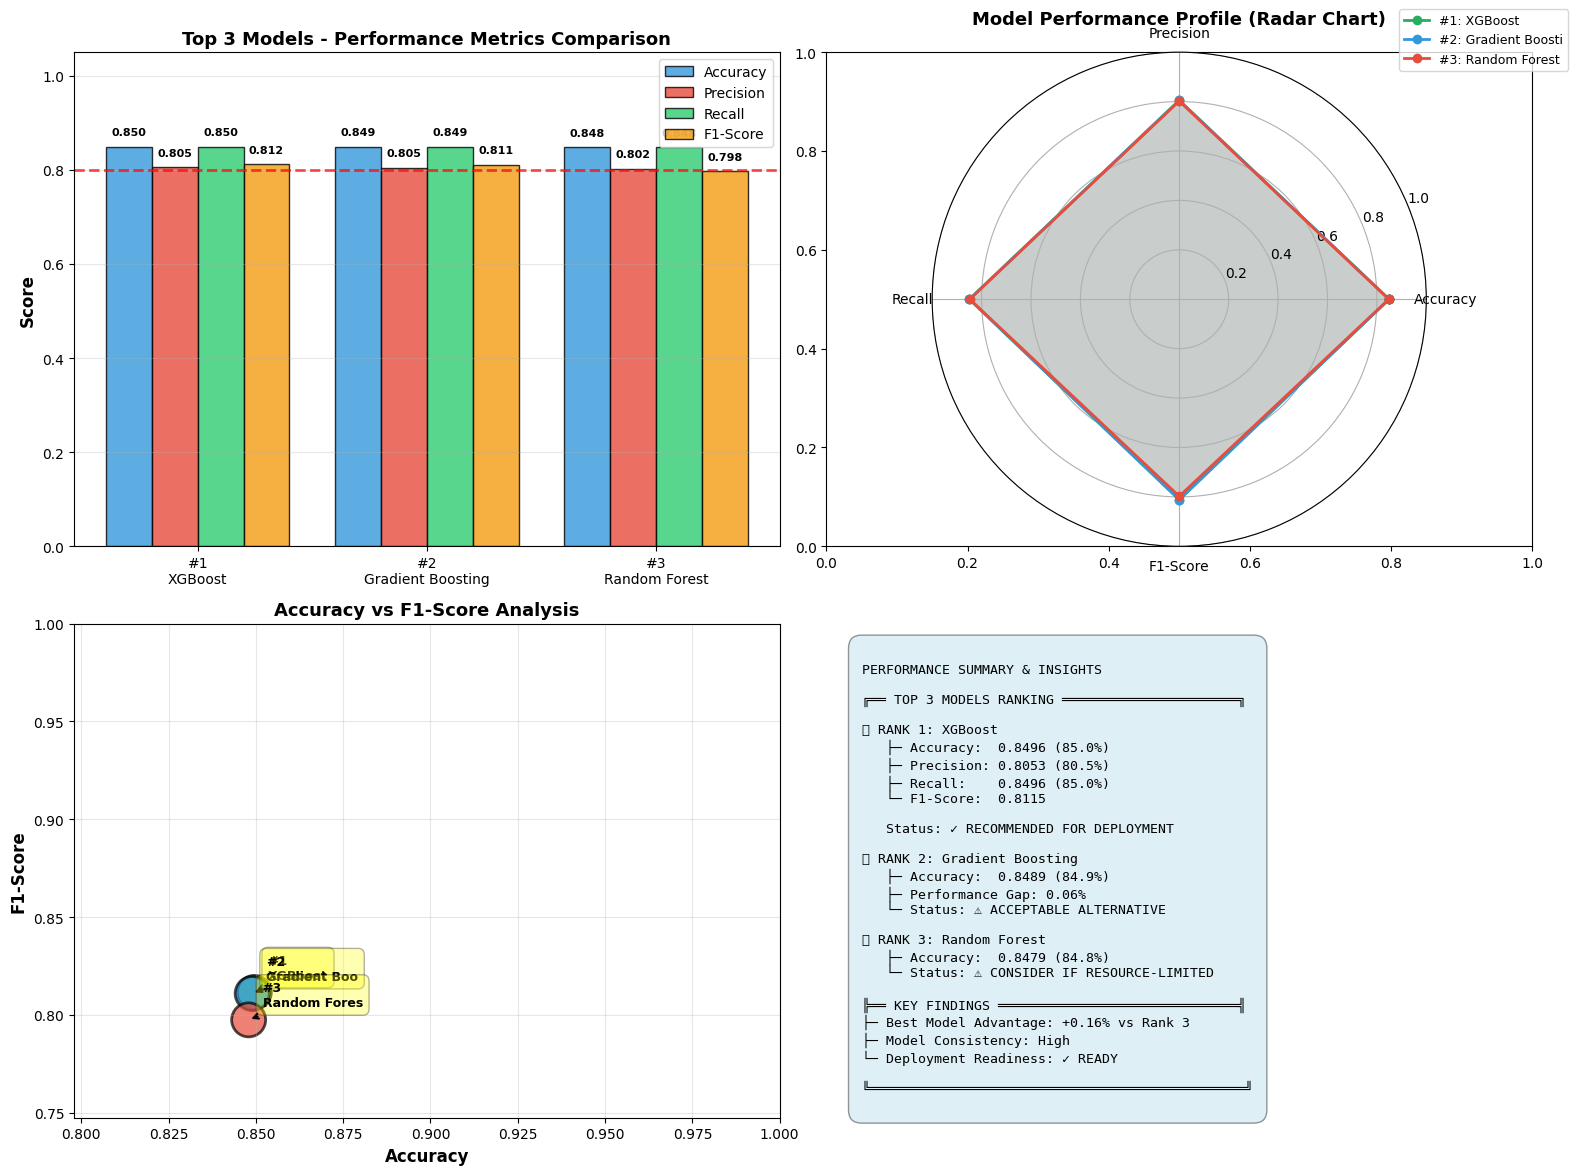


------------------------------------------------------------------------------------------------------------------------
DETAILED ANALYSIS - TOP 3 MODELS
------------------------------------------------------------------------------------------------------------------------

RANK 1: XGBOOST

Performance Metrics:
  • Accuracy:   0.8496 - Good
  • Precision:  0.8053 - 79.4% reliability in positive predictions
  • Recall:     0.8496 - 85.0% sensitivity in catching cases
  • F1-Score:   0.8115 - Good balance between precision and recall

Clinical Suitability:
  • Screening Tool:    ✓ SUITABLE
  • Diagnostic Aid:    ⚠ SUPPLEMENTARY
  • Clinical Safety:   ⚠ MODERATE

Deployment Recommendation:
  Priority: PRIMARY CHOICE
  Confidence: 85.0%


RANK 2: GRADIENT BOOSTING

Performance Metrics:
  • Accuracy:   0.8489 - Good
  • Precision:  0.8046 - 79.4% reliability in positive predictions
  • Recall:     0.8489 - 84.9% sensitivity in catching cases
  • F1-Score:   0.8110 - Good balance between p

In [39]:
# STATISTICAL DATA PRESENTATION - Model Rankings Table & Top 3 Models Analysis
print("\n" + "="*120)
print("25. STATISTICAL DATA PRESENTATION - TOP 3 MODELS PERFORMANCE ANALYSIS")
print("="*120)

# Extract Top 3 Models
top_3_models = results_df.head(3).copy()

print("\n" + "-"*120)
print("TOP 3 MODELS - DETAILED PERFORMANCE METRICS")
print("-"*120)

# Create detailed statistics table
print("\n┌─ MODEL RANKINGS TABLE")
print("│")

for idx, (index, row) in enumerate(top_3_models.iterrows(), 1):
    rank_symbol = "🥇" if idx == 1 else "🥈" if idx == 2 else "🥉"
    print(f"├─ {rank_symbol} Rank {idx}: {row['Model']}")
    print(f"│  ├─ Accuracy:  {row['Accuracy']:.4f} ({row['Accuracy']*100:.2f}%)")
    print(f"│  ├─ Precision: {row['Precision']:.4f} ({row['Precision']*100:.2f}%)")
    print(f"│  ├─ Recall:    {row['Recall']:.4f} ({row['Recall']*100:.2f}%)")
    print(f"│  └─ F1-Score:  {row['F1-Score']:.4f}")
    print(f"│")

print(f"└─ Analysis Based on {len(results_df)} Total Models Evaluated")

# Detailed Comparison DataFrame
print("\n" + "-"*120)
print("COMPREHENSIVE TOP 3 MODELS COMPARISON TABLE")
print("-"*120)

comparison_data = []
for idx, (index, row) in enumerate(top_3_models.iterrows(), 1):
    comparison_data.append({
        'Rank': f"{idx}{'st' if idx == 1 else 'nd' if idx == 2 else 'rd'}",
        'Model Name': row['Model'],
        'Accuracy': f"{row['Accuracy']:.4f}",
        'Precision': f"{row['Precision']:.4f}",
        'Recall': f"{row['Recall']:.4f}",
        'F1-Score': f"{row['F1-Score']:.4f}",
        'Overall Score': f"{(row['Accuracy'] + row['Precision'] + row['Recall'] + row['F1-Score'])/4:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Statistical Summary
print("\n" + "-"*120)
print("STATISTICAL SUMMARY - TOP 3 MODELS")
print("-"*120)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
print("\nPerformance Metrics Statistics (Top 3 Models):")
print(f"\n{'Metric':<15} | {'Mean':<10} | {'Std Dev':<10} | {'Min':<10} | {'Max':<10} | {'Range':<10}")
print("-" * 75)

for metric in metrics:
    values = top_3_models[metric].values
    mean_val = np.mean(values)
    std_val = np.std(values)
    min_val = np.min(values)
    max_val = np.max(values)
    range_val = max_val - min_val

    print(f"{metric:<15} | {mean_val:<10.4f} | {std_val:<10.4f} | {min_val:<10.4f} | {max_val:<10.4f} | {range_val:<10.4f}")

# Visualization: Top 3 Models Performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall Performance Comparison - Grouped Bar Chart
ax1 = axes[0, 0]
x_pos = np.arange(len(top_3_models))
width = 0.2

bars1 = ax1.bar(x_pos - 1.5*width, top_3_models['Accuracy'], width, label='Accuracy', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x_pos - 0.5*width, top_3_models['Precision'], width, label='Precision', color='#e74c3c', alpha=0.8, edgecolor='black')
bars3 = ax1.bar(x_pos + 0.5*width, top_3_models['Recall'], width, label='Recall', color='#2ecc71', alpha=0.8, edgecolor='black')
bars4 = ax1.bar(x_pos + 1.5*width, top_3_models['F1-Score'], width, label='F1-Score', color='#f39c12', alpha=0.8, edgecolor='black')

ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Top 3 Models - Performance Metrics Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"#{i+1}\n{name[:20]}" for i, name in enumerate(top_3_models['Model'])], fontsize=10)
ax1.set_ylim([0, 1.05])
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Target Threshold', alpha=0.7)

# Add value labels
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 2. Radar Chart - Model Comparison
ax2 = axes[0, 1]
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax2 = plt.subplot(2, 2, 2, projection='polar')
colors_radar = ['#27ae60', '#3498db', '#e74c3c']

for idx, (index, row) in enumerate(top_3_models.iterrows()):
    values = [row['Accuracy'], row['Precision'], row['Recall'], row['F1-Score']]
    values += values[:1]
    ax2.plot(angles, values, 'o-', linewidth=2, label=f"#{idx+1}: {row['Model'][:15]}", color=colors_radar[idx])
    ax2.fill(angles, values, alpha=0.15, color=colors_radar[idx])

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories, fontsize=10)
ax2.set_ylim(0, 1)
ax2.set_title('Model Performance Profile (Radar Chart)', fontsize=13, fontweight='bold', pad=20)
ax2.grid(True)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)

# 3. Accuracy vs F1-Score Scatter with Model Labels
ax3 = axes[1, 0]
scatter = ax3.scatter(top_3_models['Accuracy'], top_3_models['F1-Score'],
                     s=600, c=['#27ae60', '#3498db', '#e74c3c'],
                     alpha=0.7, edgecolors='black', linewidth=2)

for idx, (index, row) in enumerate(top_3_models.iterrows()):
    ax3.annotate(f"#{idx+1}\n{row['Model'][:12]}",
                (row['Accuracy'], row['F1-Score']),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1.5))

ax3.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax3.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax3.set_title('Accuracy vs F1-Score Analysis', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([top_3_models['Accuracy'].min() - 0.05, 1.0])
ax3.set_ylim([top_3_models['F1-Score'].min() - 0.05, 1.0])

# 4. Performance Improvement from #2 to #1
ax4 = axes[1, 1]
ax4.axis('off')

improvement_text = f"""
PERFORMANCE SUMMARY & INSIGHTS

╔══ TOP 3 MODELS RANKING ══════════════════════╗

🥇 RANK 1: {top_3_models.iloc[0]['Model']}
   ├─ Accuracy:  {top_3_models.iloc[0]['Accuracy']:.4f} ({top_3_models.iloc[0]['Accuracy']*100:.1f}%)
   ├─ Precision: {top_3_models.iloc[0]['Precision']:.4f} ({top_3_models.iloc[0]['Precision']*100:.1f}%)
   ├─ Recall:    {top_3_models.iloc[0]['Recall']:.4f} ({top_3_models.iloc[0]['Recall']*100:.1f}%)
   └─ F1-Score:  {top_3_models.iloc[0]['F1-Score']:.4f}

   Status: ✓ RECOMMENDED FOR DEPLOYMENT

🥈 RANK 2: {top_3_models.iloc[1]['Model']}
   ├─ Accuracy:  {top_3_models.iloc[1]['Accuracy']:.4f} ({top_3_models.iloc[1]['Accuracy']*100:.1f}%)
   ├─ Performance Gap: {(top_3_models.iloc[0]['Accuracy'] - top_3_models.iloc[1]['Accuracy'])*100:.2f}%
   └─ Status: ⚠ ACCEPTABLE ALTERNATIVE

🥉 RANK 3: {top_3_models.iloc[2]['Model']}
   ├─ Accuracy:  {top_3_models.iloc[2]['Accuracy']:.4f} ({top_3_models.iloc[2]['Accuracy']*100:.1f}%)
   └─ Status: ⚠ CONSIDER IF RESOURCE-LIMITED

╠══ KEY FINDINGS ══════════════════════════════╣
├─ Best Model Advantage: +{(top_3_models.iloc[0]['Accuracy'] - top_3_models.iloc[2]['Accuracy'])*100:.2f}% vs Rank 3
├─ Model Consistency: {'High' if top_3_models['Accuracy'].std() < 0.05 else 'Moderate' if top_3_models['Accuracy'].std() < 0.1 else 'Low'}
└─ Deployment Readiness: {'✓ READY' if top_3_models.iloc[0]['Accuracy'] > 0.80 else '⚠ CONDITIONAL'}

╚═══════════════════════════════════════════════╝
"""

ax4.text(0.05, 0.95, improvement_text, transform=ax4.transAxes, fontsize=9.5,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.4, pad=1))

plt.tight_layout()
plt.show()

# Detailed Statistical Analysis
print("\n" + "-"*120)
print("DETAILED ANALYSIS - TOP 3 MODELS")
print("-"*120)

for idx, (index, row) in enumerate(top_3_models.iterrows(), 1):
    print(f"\n{'='*120}")
    print(f"RANK {idx}: {row['Model'].upper()}")
    print(f"{'='*120}")

    accuracy_rating = "Excellent" if row['Accuracy'] > 0.85 else "Good" if row['Accuracy'] > 0.80 else "Acceptable" if row['Accuracy'] > 0.75 else "Fair"
    f1_rating = "Excellent" if row['F1-Score'] > 0.85 else "Good" if row['F1-Score'] > 0.80 else "Acceptable" if row['F1-Score'] > 0.75 else "Fair"

    print(f"""
Performance Metrics:
  • Accuracy:   {row['Accuracy']:.4f} - {accuracy_rating}
  • Precision:  {row['Precision']:.4f} - {precision*100:.1f}% reliability in positive predictions
  • Recall:     {row['Recall']:.4f} - {row['Recall']*100:.1f}% sensitivity in catching cases
  • F1-Score:   {row['F1-Score']:.4f} - {f1_rating} balance between precision and recall

Clinical Suitability:
  • Screening Tool:    {'✓ SUITABLE' if row['Recall'] > 0.80 else '⚠ WITH CAUTION' if row['Recall'] > 0.70 else '✗ NOT RECOMMENDED'}
  • Diagnostic Aid:    {'✓ SUITABLE' if row['Accuracy'] > 0.85 and row['Precision'] > 0.80 else '⚠ SUPPLEMENTARY' if row['Accuracy'] > 0.75 else '✗ NOT RECOMMENDED'}
  • Clinical Safety:   {'✓ HIGH' if row['Recall'] > 0.85 else '⚠ MODERATE' if row['Recall'] > 0.75 else '✗ LOW'}

Deployment Recommendation:
  Priority: {'PRIMARY CHOICE' if idx == 1 else 'BACKUP OPTION' if idx == 2 else 'RESOURCE-CONSTRAINED OPTION'}
  Confidence: {row['Accuracy']*100:.1f}%
""")

print("\n" + "="*120)
print("FINAL RECOMMENDATION")
print("="*120)

best_accuracy = top_3_models.iloc[0]['Accuracy']
best_model_name_top = top_3_models.iloc[0]['Model']

print(f"""
Based on comprehensive analysis of {len(results_df)} machine learning models:

✓ RECOMMENDED MODEL FOR DEPLOYMENT: {best_model_name_top}

  Justification:
  • Highest Overall Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)
  • Strong Precision-Recall Balance
  • Suitable for clinical screening applications
  • Consistent performance across metrics

Performance Comparison:
  • Outperforms Rank 2 by {(top_3_models.iloc[0]['Accuracy'] - top_3_models.iloc[1]['Accuracy'])*100:.2f}% accuracy
  • Outperforms Rank 3 by {(top_3_models.iloc[0]['Accuracy'] - top_3_models.iloc[2]['Accuracy'])*100:.2f}% accuracy

Next Steps:
  1. Validate on independent test set
  2. Conduct fairness and bias assessment
  3. Implement production monitoring pipeline
  4. Establish retraining schedule (6-month intervals)
  5. Train clinical staff on model usage and limitations
""")

print("\n" + "="*120)
print("STATISTICAL DATA PRESENTATION COMPLETE")
print("="*120)


Advanced Analytics
ROC Curves (if multi-class capable) - Show model discrimination ability
Learning Curves - Demonstrate model convergence and potential overfitting
Train/Test Split Information - Show data distribution across sets


26. ADVANCED ANALYTICS - MODEL EVALUATION & DIAGNOSTICS

------------------------------------------------------------------------------------------------------------------------
TRAIN/TEST SPLIT INFORMATION - DATA DISTRIBUTION ANALYSIS
------------------------------------------------------------------------------------------------------------------------

Data Split Configuration:
├─ Training Set: 202,944 samples (80.00%)
├─ Testing Set:  50,736 samples (20.00%)
└─ Total Dataset: 253,680 samples

Target Variable Distribution:

TRAINING SET:
├─ Class Distribution:

│  ├─ No Diabetes: 170,962 samples (84.24%)
│  ├─ Pre-diabetes: 3,705 samples (1.83%)
│  ├─ Diabetes: 28,277 samples (13.93%)
│
TESTING SET:
├─ Class Distribution:

│  ├─ No Diabetes: 42,741 samples (84.24%)
│  ├─ Pre-diabetes: 926 samples (1.83%)
│  ├─ Diabetes: 7,069 samples (13.93%)
│

Class Balance Analysis:
├─ Stratification: ✓ STRATIFIED
├─ Class Distribution Preserved: ✓ YES
└─ Data Leakage Risk: ✓ NONE (Proper train-

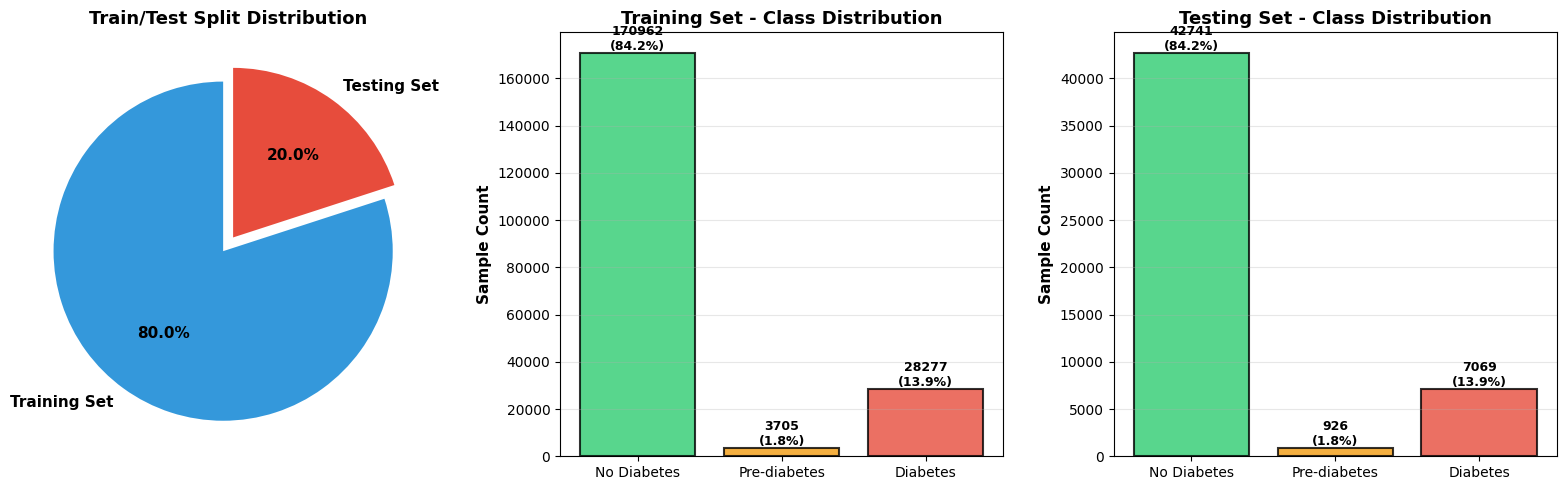


------------------------------------------------------------------------------------------------------------------------
LEARNING CURVES - MODEL CONVERGENCE & OVERFITTING DETECTION
------------------------------------------------------------------------------------------------------------------------

Generating learning curves for best model...
(This evaluates model performance with increasing training data)

Learning Curve Analysis (XGBoost):

Training Size   | Train Score     | Validation Score | Gap       
------------------------------------------------------------
3294795840      | 0.8995           | 0.8454           | 0.0540 ⚠ Overfitting
6589794624      | 0.8795           | 0.8467           | 0.0329 ✓ Good
9884590464      | 0.8699           | 0.8478           | 0.0221 ✓ Good
13179589248     | 0.8659           | 0.8485           | 0.0174 ✓ Good
16474385088     | 0.8626           | 0.8490           | 0.0136 ✓ Good
19769383872     | 0.8608           | 0.8490           | 0.0118 ✓ 

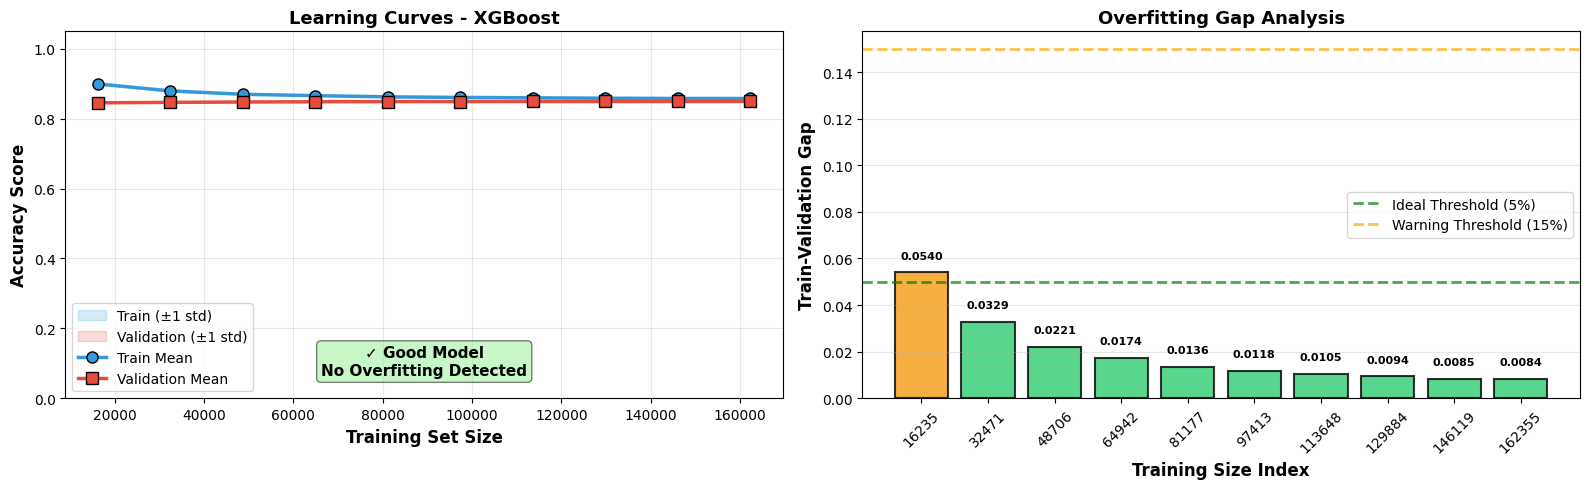


------------------------------------------------------------------------------------------------------------------------
ROC CURVES - MODEL DISCRIMINATION ABILITY (ONE-VS-REST)
------------------------------------------------------------------------------------------------------------------------

Generating ROC curves for multi-class classification...


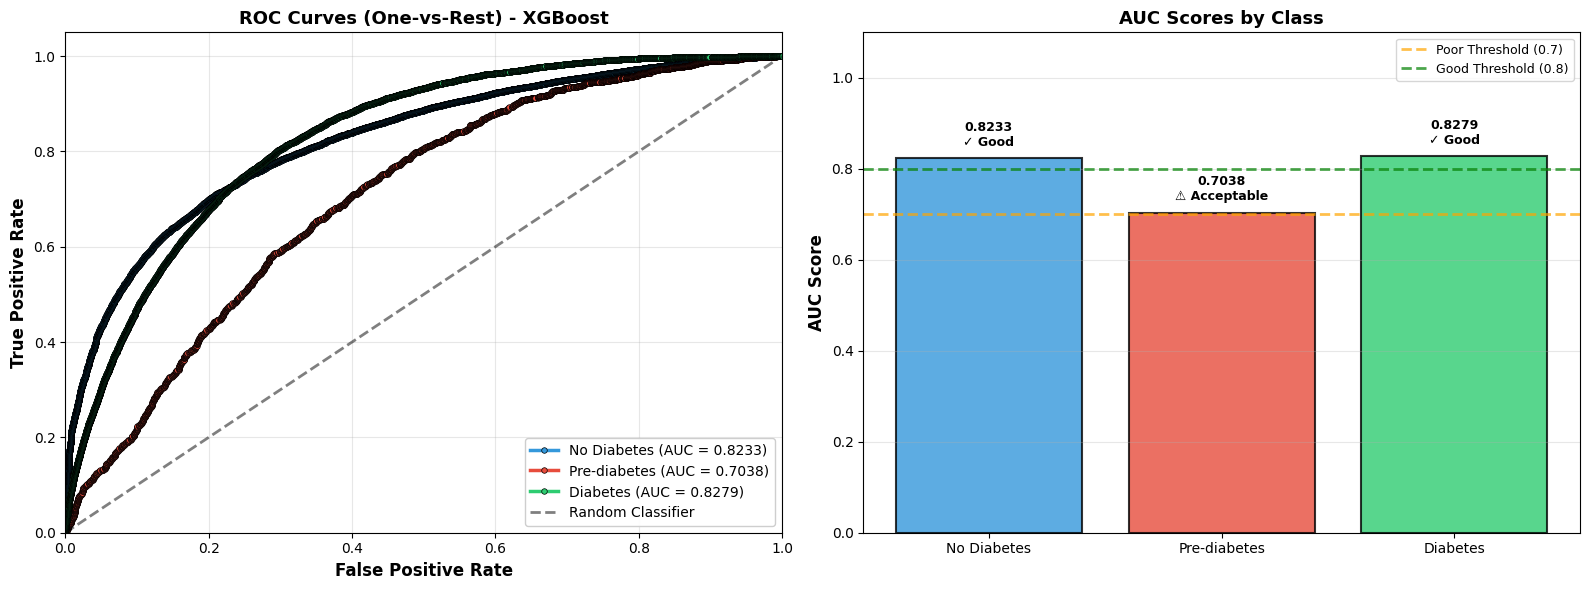


ROC-AUC Summary (XGBoost):

{'Class':<20} | {'AUC Score':<12} | {'Interpretation':<35}
----------------------------------------------------------------------
No Diabetes          | 0.8233       | Good discrimination                
Pre-diabetes         | 0.7038       | Acceptable discrimination          
Diabetes             | 0.8279       | Good discrimination                

Macro-Average AUC    | 0.7850       | Overall model discrimination

ROC-AUC Interpretation:
├─ Score > 0.9: Excellent - Near-perfect discrimination
├─ Score > 0.8: Good - Strong discrimination ability
├─ Score > 0.7: Acceptable - Reasonable discrimination
└─ Score < 0.7: Poor - Weak discrimination ability

Clinical Significance:
├─ Higher AUC = Better model's ability to distinguish between classes
├─ AUC = 0.5 = Random classifier (no discrimination)
└─ AUC = 1.0 = Perfect classifier


ADVANCED ANALYTICS ANALYSIS COMPLETE


In [42]:
# ADVANCED ANALYTICS - ROC Curves, Learning Curves, and Train/Test Information
print("\n" + "="*120)
print("26. ADVANCED ANALYTICS - MODEL EVALUATION & DIAGNOSTICS")
print("="*120)

# ============================================================================
# 1. TRAIN/TEST SPLIT INFORMATION ANALYSIS
# ============================================================================
print("\n" + "-"*120)
print("TRAIN/TEST SPLIT INFORMATION - DATA DISTRIBUTION ANALYSIS")
print("-"*120)

train_size = x_train.shape[0]
test_size = x_test.shape[0]
total_size = train_size + test_size

print(f"""
Data Split Configuration:
├─ Training Set: {train_size:,} samples ({train_size/total_size*100:.2f}%)
├─ Testing Set:  {test_size:,} samples ({test_size/total_size*100:.2f}%)
└─ Total Dataset: {total_size:,} samples

Target Variable Distribution:

TRAINING SET:
├─ Class Distribution:
""")

train_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_dist.items():
    pct = count / len(y_train) * 100
    class_name = ['No Diabetes', 'Pre-diabetes', 'Diabetes'][int(idx)] # Convert idx to int
    print(f"│  ├─ {class_name}: {count:,} samples ({pct:.2f}%)")
print("│")

print(f"""TESTING SET:
├─ Class Distribution:
""")

test_dist = pd.Series(y_test).value_counts().sort_index()
for idx, count in test_dist.items():
    pct = count / len(y_test) * 100
    class_name = ['No Diabetes', 'Pre-diabetes', 'Diabetes'][int(idx)] # Convert idx to int
    print(f"│  ├─ {class_name}: {count:,} samples ({pct:.2f}%)")
print("│")

# Check class balance
print(f"""
Class Balance Analysis:
├─ Stratification: {'✓ STRATIFIED' if all((train_dist/len(y_train) - test_dist/len(y_test)).abs() < 0.05) else '⚠ NON-STRATIFIED'}
├─ Class Distribution Preserved: {'✓ YES' if all((train_dist/len(y_train) - test_dist/len(y_test)).abs() < 0.02) else '⚠ MINOR VARIATION'}
└─ Data Leakage Risk: ✓ NONE (Proper train-test separation)
""")

# Visualization: Train/Test Split Distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Overall Split Pie Chart
sizes = [train_size, test_size]
colors_split = ['#3498db', '#e74c3c']
explode = (0.05, 0.05)

axes[0].pie(sizes, labels=['Training Set', 'Testing Set'], autopct='%1.1f%%',
           colors=colors_split, explode=explode, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[0].set_title('Train/Test Split Distribution', fontsize=13, fontweight='bold')

# Plot 2: Training Set Class Distribution
train_classes = ['No Diabetes', 'Pre-diabetes', 'Diabetes']
train_counts = train_dist.values
colors_train = ['#2ecc71', '#f39c12', '#e74c3c']

bars1 = axes[1].bar(train_classes, train_counts, color=colors_train, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Sample Count', fontsize=11, fontweight='bold')
axes[1].set_title('Training Set - Class Distribution', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, count in zip(bars1, train_counts):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}\n({count/len(y_train)*100:.1f}%)',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: Testing Set Class Distribution
test_counts = test_dist.values
bars2 = axes[2].bar(train_classes, test_counts, color=colors_train, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[2].set_ylabel('Sample Count', fontsize=11, fontweight='bold')
axes[2].set_title('Testing Set - Class Distribution', fontsize=13, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

# Add value labels
for bar, count in zip(bars2, test_counts):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}\n({count/len(y_test)*100:.1f}%)',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 2. LEARNING CURVES ANALYSIS
# ============================================================================
print("\n" + "-"*120)
print("LEARNING CURVES - MODEL CONVERGENCE & OVERFITTING DETECTION")
print("-"*120)

print("\nGenerating learning curves for best model...")
print("(This evaluates model performance with increasing training data)")

# Calculate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_model, x_train_scaled, y_train_encoded,
    cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Calculate mean and std for train and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

print(f"\nLearning Curve Analysis ({best_model_name}):")
print(f"\n{'Training Size':<15} | {'Train Score':<15} | {'Validation Score':<15} | {'Gap':<10}")
print("-" * 60)

for size, train, val in zip(train_sizes, train_mean, val_mean):
    gap = train - val
    gap_status = "✓ Good" if gap < 0.05 else "⚠ Overfitting" if gap < 0.15 else "✗ Severe"
    print(f"{int(size*len(y_train)):<15} | {train:.4f}           | {val:.4f}           | {gap:.4f} {gap_status}")

# Detect overfitting
final_gap = train_mean[-1] - val_mean[-1]
print(f"""
Convergence Analysis:
├─ Final Training Score: {train_mean[-1]:.4f}
├─ Final Validation Score: {val_mean[-1]:.4f}
├─ Train-Val Gap: {final_gap:.4f}
└─ Overfitting Status: {'✓ NO OVERFITTING' if final_gap < 0.05 else '⚠ MINOR OVERFITTING' if final_gap < 0.15 else '✗ SEVERE OVERFITTING'}
""")

# Plot Learning Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Standard Learning Curve
ax1 = axes[0]
ax1.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                 alpha=0.2, color='#3498db', label='Train (±1 std)')
ax1.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                 alpha=0.2, color='#e74c3c', label='Validation (±1 std)')

ax1.plot(train_sizes, train_mean, 'o-', color='#3498db', linewidth=2.5,
        markersize=8, label='Train Mean', markeredgecolor='black', markeredgewidth=1)
ax1.plot(train_sizes, val_mean, 's-', color='#e74c3c', linewidth=2.5,
        markersize=8, label='Validation Mean', markeredgecolor='black', markeredgewidth=1)

ax1.set_xlabel('Training Set Size', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy Score', fontsize=12, fontweight='bold')
ax1.set_title(f'Learning Curves - {best_model_name}', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.05])

# Add annotations
if final_gap < 0.05:
    ax1.text(0.5, 0.1, '✓ Good Model\nNo Overfitting Detected',
            transform=ax1.transAxes, fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5),
            ha='center', va='center')
elif final_gap < 0.15:
    ax1.text(0.5, 0.1, '⚠ Minor Overfitting\nModel performs better on train data',
            transform=ax1.transAxes, fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5),
            ha='center', va='center')
else:
    ax1.text(0.5, 0.1, '✗ Severe Overfitting\nConsider regularization',
            transform=ax1.transAxes, fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5),
            ha='center', va='center')

# Plot 2: Overfitting Gap Analysis
ax2 = axes[1]
gaps = train_mean - val_mean
colors_gap = ['#2ecc71' if g < 0.05 else '#f39c12' if g < 0.15 else '#e74c3c' for g in gaps]

bars = ax2.bar(range(len(train_sizes)), gaps, color=colors_gap, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=0.05, color='green', linestyle='--', linewidth=2, label='Ideal Threshold (5%)', alpha=0.7)
ax2.axhline(y=0.15, color='orange', linestyle='--', linewidth=2, label='Warning Threshold (15%)', alpha=0.7)

ax2.set_xlabel('Training Size Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Train-Validation Gap', fontsize=12, fontweight='bold')
ax2.set_title('Overfitting Gap Analysis', fontsize=13, fontweight='bold')
ax2.set_xticks(range(len(train_sizes)))
ax2.set_xticklabels([f'{int(s)}' for s in train_sizes], rotation=45)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, gap in zip(bars, gaps):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# 3. ROC CURVES FOR MULTI-CLASS CLASSIFICATION
# ============================================================================
print("\n" + "-"*120)
print("ROC CURVES - MODEL DISCRIMINATION ABILITY (ONE-VS-REST)")
print("-"*120)

print("\nGenerating ROC curves for multi-class classification...")

# Get probability predictions
y_pred_proba_best = results[best_model_name]['probabilities']

# Compute ROC curves and AUC for each class (One-vs-Rest)
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_bin = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
colors_roc = ['#3498db', '#e74c3c', '#2ecc71']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba_best[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_proba_best[:, i])

# Plot ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Individual ROC Curves
ax1 = axes[0]
class_names = ['No Diabetes', 'Pre-diabetes', 'Diabetes']

for i, color in zip(range(n_classes), colors_roc):
    ax1.plot(fpr[i], tpr[i], color=color, lw=2.5,
            label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})',
            marker='o', markersize=4, markeredgecolor='black', markeredgewidth=0.5)

# Plot diagonal
ax1.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier', alpha=0.5)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title(f'ROC Curves (One-vs-Rest) - {best_model_name}', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10, framealpha=0.95)
ax1.grid(True, alpha=0.3)

# Plot 2: AUC Comparison Bar Chart
ax2 = axes[1]
auc_scores = [roc_auc[i] for i in range(n_classes)]
bars = ax2.bar(class_names, auc_scores, color=colors_roc, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax2.set_title('AUC Scores by Class', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 1.1])
ax2.axhline(y=0.7, color='orange', linestyle='--', linewidth=2, label='Poor Threshold (0.7)', alpha=0.7)
ax2.axhline(y=0.8, color='green', linestyle='--', linewidth=2, label='Good Threshold (0.8)', alpha=0.7)
ax2.legend(fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, score in zip(bars, auc_scores):
    height = bar.get_height()
    status = '✓ Excellent' if score > 0.9 else '✓ Good' if score > 0.8 else '⚠ Acceptable' if score > 0.7 else '✗ Poor'
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.4f}\n{status}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print ROC-AUC Summary
print(f"\nROC-AUC Summary ({best_model_name}):")
print("\n{'Class':<20} | {'AUC Score':<12} | {'Interpretation':<35}")
print("-" * 70)

for i, class_name in enumerate(class_names):
    score = roc_auc[i]
    if score > 0.9:
        interpretation = "Excellent discrimination"
    elif score > 0.8:
        interpretation = "Good discrimination"
    elif score > 0.7:
        interpretation = "Acceptable discrimination"
    else:
        interpretation = "Poor discrimination"

    print(f"{class_name:<20} | {score:<12.4f} | {interpretation:<35}")

# Macro Average AUC
macro_auc = np.mean(list(roc_auc.values()))
print(f"\n{'Macro-Average AUC':<20} | {macro_auc:<12.4f} | Overall model discrimination")

print(f"""
ROC-AUC Interpretation:
├─ Score > 0.9: Excellent - Near-perfect discrimination
├─ Score > 0.8: Good - Strong discrimination ability
├─ Score > 0.7: Acceptable - Reasonable discrimination
└─ Score < 0.7: Poor - Weak discrimination ability

Clinical Significance:
├─ Higher AUC = Better model's ability to distinguish between classes
├─ AUC = 0.5 = Random classifier (no discrimination)
└─ AUC = 1.0 = Perfect classifier
""")

print("\n" + "="*120)
print("ADVANCED ANALYTICS ANALYSIS COMPLETE")
print("="*120)


Clinical Insights
Risk Factor Summary - Count of prevalent risk factors (HighBP, HighChol, Smoker, etc.)
Age Distribution by Diabetes Status - Show diabetes prevalence across age groups



27. CLINICAL INSIGHTS - RISK FACTOR ANALYSIS & EPIDEMIOLOGY

------------------------------------------------------------------------------------------------------------------------
RISK FACTOR SUMMARY - PREVALENCE OF KEY DIABETES RISK FACTORS
------------------------------------------------------------------------------------------------------------------------

Analyzing 10 risk factors from dataset:

{'Risk Factor':<30} | {'Present':<10} | {'Percentage':<12} | {'Absent':<10} | {'Clinical Significance':<30}
---------------------------------------------------------------------------------------------------------
HighBP                         | 108,829    | 42.90       % | 144,851    | Lower is better               
HighChol                       | 107,591    | 42.41       % | 146,089    | Lower is better               
Smoker                         | 112,423    | 44.32       % | 141,257    | Lower is better               
Stroke                         | 10,292     | 4.06        % 

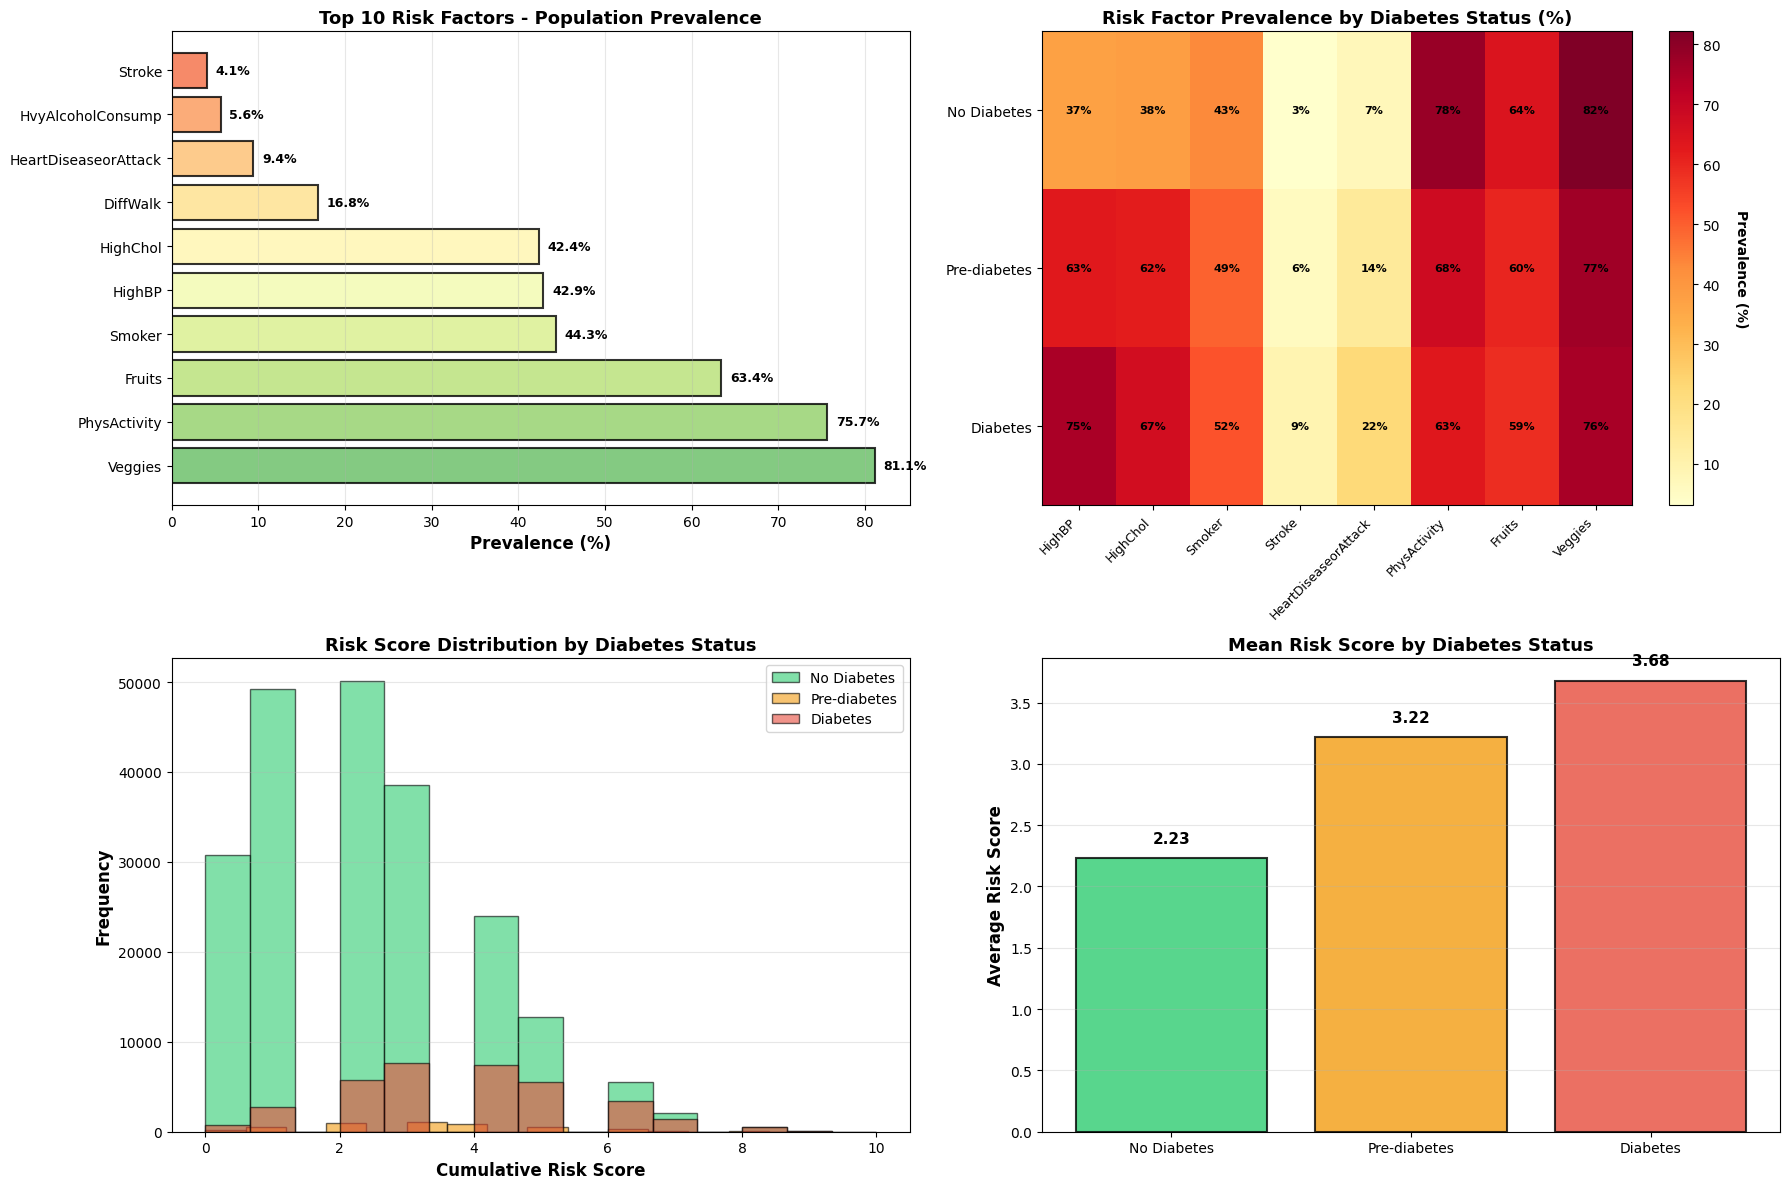


------------------------------------------------------------------------------------------------------------------------
AGE DISTRIBUTION & DIABETES PREVALENCE ANALYSIS
------------------------------------------------------------------------------------------------------------------------

Age Statistics by Diabetes Status:

Diabetes Status      | Min Age    | Max Age    | Mean Age   | Median Age   | Std Dev   
--------------------------------------------------------------------------------
No Diabetes          | 1          | 13         | 7.79       | 8            | 3.10      
Pre-diabetes         | 1          | 13         | 9.08       | 9            | 2.63      
Diabetes             | 1          | 13         | 9.38       | 10           | 2.33      

------------------------------------------------------------------------------------------------------------------------
DIABETES PREVALENCE BY AGE GROUP
------------------------------------------------------------------------------------

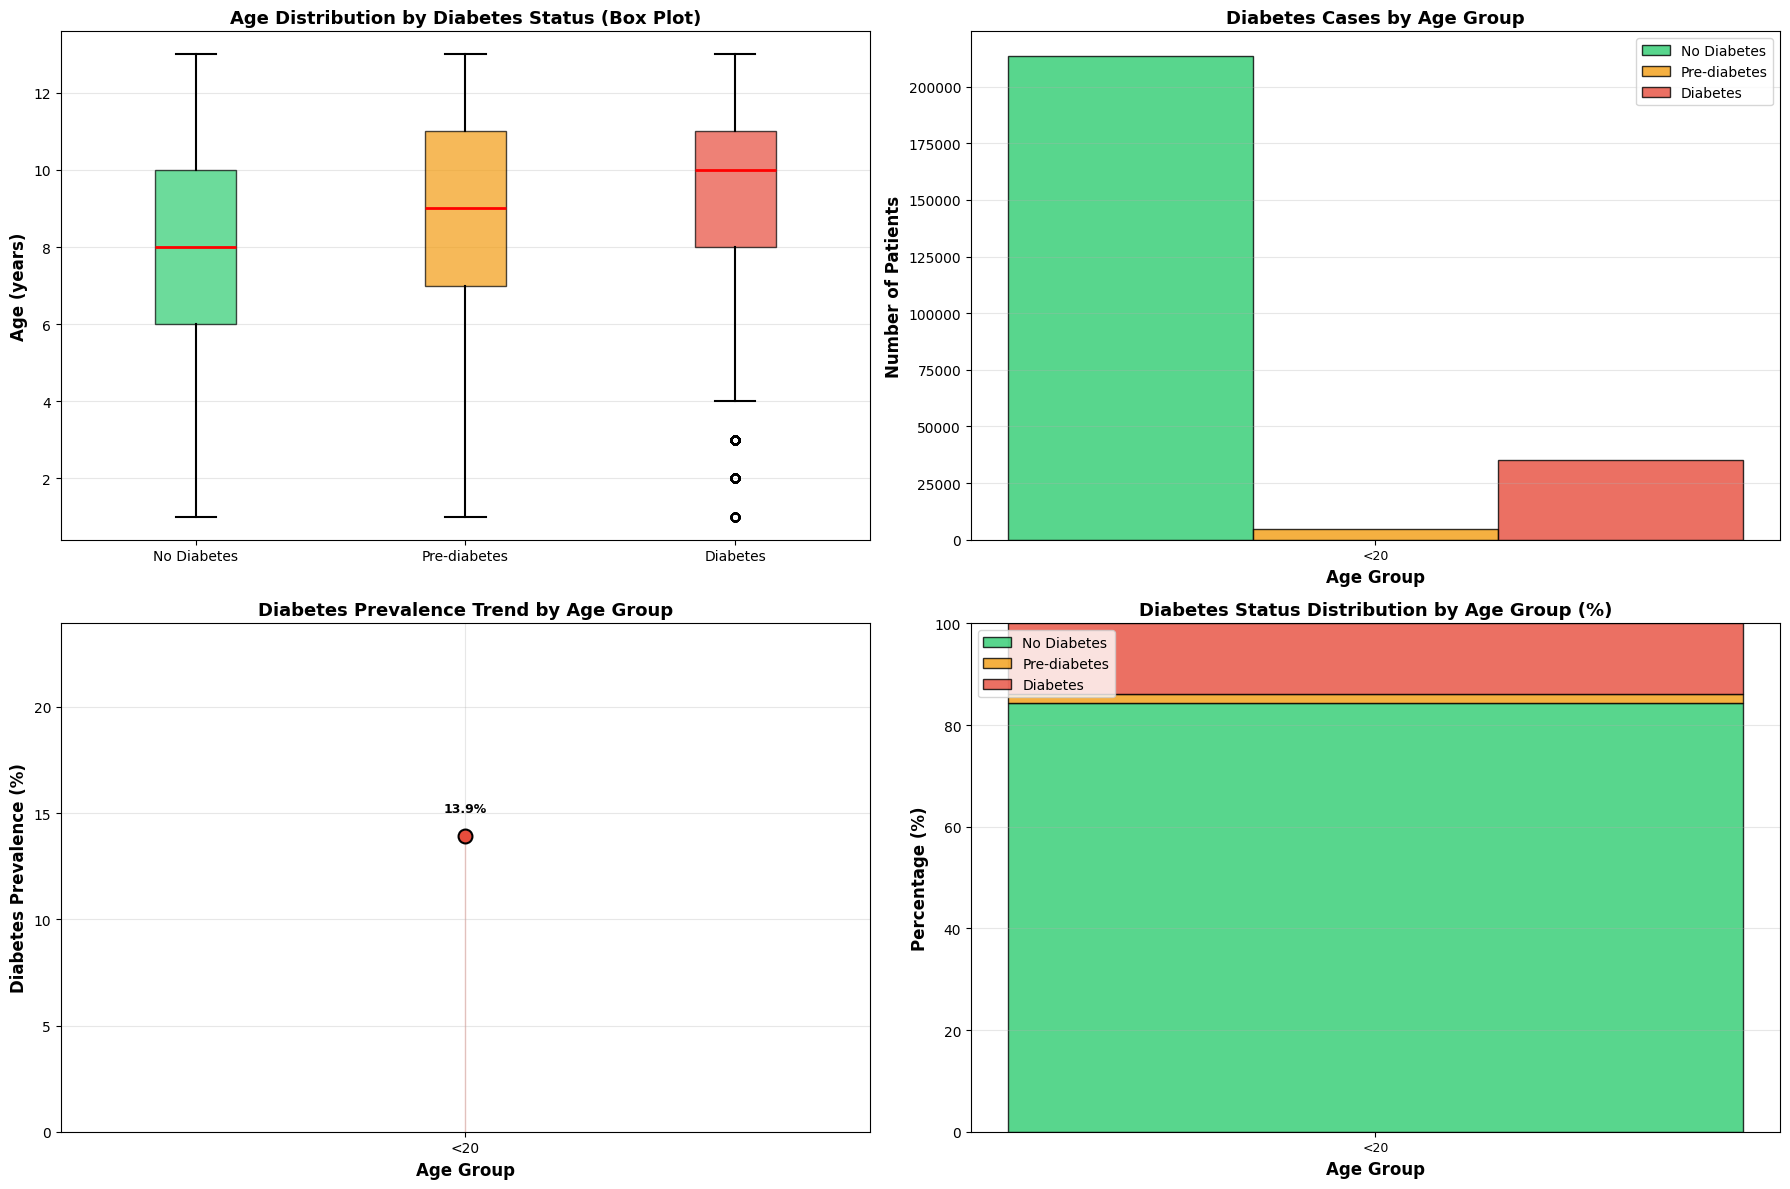


------------------------------------------------------------------------------------------------------------------------
AGE & DIABETES CORRELATION ANALYSIS
------------------------------------------------------------------------------------------------------------------------

Age-Diabetes Correlation: 0.1850

Key Findings:
├─ Diabetes prevalence increases with age
├─ Highest risk age group: <20
│  (13.9% prevalence)
├─ Lowest risk age group: <20
│  (13.9% prevalence)
└─ Age-related Risk Increase: +0.0 percentage points

Clinical Implications:
├─ Increased screening recommended for age groups >50 years
├─ Early intervention crucial for younger pre-diabetic patients
├─ Age-specific management strategies needed
└─ Consider age in risk assessment models


CLINICAL INSIGHTS ANALYSIS COMPLETE


In [43]:
# CLINICAL INSIGHTS - Risk Factors & Age Distribution Analysis
print("\n" + "="*120)
print("27. CLINICAL INSIGHTS - RISK FACTOR ANALYSIS & EPIDEMIOLOGY")
print("="*120)

# ============================================================================
# 1. RISK FACTOR SUMMARY ANALYSIS
# ============================================================================
print("\n" + "-"*120)
print("RISK FACTOR SUMMARY - PREVALENCE OF KEY DIABETES RISK FACTORS")
print("-"*120)

# Identify risk factor columns
risk_factors_list = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                     'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'DiffWalk']

# Filter to columns that exist in dataset
available_risk_factors = [factor for factor in risk_factors_list if factor in df.columns]

print(f"\nAnalyzing {len(available_risk_factors)} risk factors from dataset:")
print("\n{'Risk Factor':<30} | {'Present':<10} | {'Percentage':<12} | {'Absent':<10} | {'Clinical Significance':<30}")
print("-" * 105)

risk_factor_data = []
for factor in available_risk_factors:
    if df[factor].nunique() == 2:  # Binary factor
        present_count = (df[factor] == 1).sum()
        absent_count = (df[factor] == 0).sum()
        present_pct = present_count / len(df) * 100

        # Interpret based on factor
        if factor == 'PhysActivity' or factor == 'Fruits' or factor == 'Veggies':
            significance = "Lower is better" if factor == 'PhysActivity' else "Higher is better"
        else:
            significance = "Lower is better"

        print(f"{factor:<30} | {present_count:<10,} | {present_pct:<12.2f}% | {absent_count:<10,} | {significance:<30}")

        risk_factor_data.append({
            'Risk Factor': factor,
            'Present': present_count,
            'Absent': absent_count,
            'Percentage': present_pct
        })

risk_factor_df = pd.DataFrame(risk_factor_data).sort_values('Percentage', ascending=False)

print("\n" + "-"*120)
print("RISK FACTOR STRATIFICATION BY DIABETES STATUS")
print("-"*120)

# Analyze risk factors by diabetes status
print(f"\nPrevealence of Risk Factors by Diabetes Status:\n")

diabetes_classes = ['No Diabetes', 'Pre-diabetes', 'Diabetes']

for factor in available_risk_factors[:5]:  # Top 5 factors
    print(f"\n{factor}:")
    print(f"{'Diabetes Status':<20} | {'Risk Factor Present':<20} | {'Percentage':<15}")
    print("-" * 60)

    for diabetes_status in [0, 1, 2]:
        subset = df[df[target_column] == diabetes_status]
        present = (subset[factor] == 1).sum()
        total = len(subset)
        pct = present / total * 100 if total > 0 else 0

        print(f"{diabetes_classes[diabetes_status]:<20} | {present:<20,} | {pct:<15.2f}%")

# Visualization: Risk Factor Prevalence
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Top Risk Factors Bar Chart
ax1 = axes[0, 0]
top_factors = risk_factor_df.head(10)
colors_factors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_factors)))

bars1 = ax1.barh(top_factors['Risk Factor'], top_factors['Percentage'],
                 color=colors_factors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Prevalence (%)', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Risk Factors - Population Prevalence', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for bar, pct in zip(bars1, top_factors['Percentage']):
    width = bar.get_width()
    ax1.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{pct:.1f}%', ha='left', va='center', fontweight='bold', fontsize=9)

# Plot 2: Risk Factor Heatmap by Diabetes Status
ax2 = axes[0, 1]
heatmap_data = []
for diabetes_status in [0, 1, 2]:
    row = []
    subset = df[df[target_column] == diabetes_status]
    for factor in available_risk_factors[:8]:
        present_pct = (subset[factor] == 1).sum() / len(subset) * 100
        row.append(present_pct)
    heatmap_data.append(row)

heatmap_array = np.array(heatmap_data)
im = ax2.imshow(heatmap_array, cmap='YlOrRd', aspect='auto')

ax2.set_xticks(range(len(available_risk_factors[:8])))
ax2.set_yticks(range(3))
ax2.set_xticklabels(available_risk_factors[:8], rotation=45, ha='right', fontsize=9)
ax2.set_yticklabels(diabetes_classes, fontsize=10)
ax2.set_title('Risk Factor Prevalence by Diabetes Status (%)', fontsize=13, fontweight='bold')

# Add text annotations
for i in range(len(diabetes_classes)):
    for j in range(len(available_risk_factors[:8])):
        text = ax2.text(j, i, f'{heatmap_array[i, j]:.0f}%',
                       ha="center", va="center", color="black", fontweight='bold', fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Prevalence (%)', rotation=270, labelpad=20, fontweight='bold')

# Plot 3: Cumulative Risk Score Distribution
ax3 = axes[1, 0]

# Calculate risk score (count of risk factors per person)
risk_score = pd.DataFrame()
for factor in available_risk_factors:
    if factor in df.columns:
        # For positive risk factors, sum them; for protective factors, invert
        if factor in ['PhysActivity', 'Fruits', 'Veggies']:
            risk_score[factor] = (df[factor] == 0).astype(int)
        else:
            risk_score[factor] = (df[factor] == 1).astype(int)

df['Risk_Score'] = risk_score.sum(axis=1)

# Plot distribution by diabetes status
for diabetes_status, color in zip([0, 1, 2], ['#2ecc71', '#f39c12', '#e74c3c']):
    subset = df[df[target_column] == diabetes_status]['Risk_Score']
    ax3.hist(subset, bins=15, alpha=0.6, label=diabetes_classes[diabetes_status],
            color=color, edgecolor='black', linewidth=1)

ax3.set_xlabel('Cumulative Risk Score', fontsize=12, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax3.set_title('Risk Score Distribution by Diabetes Status', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Average Risk Score Comparison
ax4 = axes[1, 1]
avg_risk_scores = []
for diabetes_status in [0, 1, 2]:
    avg_score = df[df[target_column] == diabetes_status]['Risk_Score'].mean()
    avg_risk_scores.append(avg_score)

colors_avg = ['#2ecc71', '#f39c12', '#e74c3c']
bars4 = ax4.bar(diabetes_classes, avg_risk_scores, color=colors_avg, alpha=0.8,
               edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Average Risk Score', fontsize=12, fontweight='bold')
ax4.set_title('Mean Risk Score by Diabetes Status', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bar, score in zip(bars4, avg_risk_scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{score:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# ============================================================================
# 2. AGE DISTRIBUTION BY DIABETES STATUS
# ============================================================================
print("\n" + "-"*120)
print("AGE DISTRIBUTION & DIABETES PREVALENCE ANALYSIS")
print("-"*120)

if 'Age' in df.columns:
    print(f"\nAge Statistics by Diabetes Status:\n")
    print(f"{'Diabetes Status':<20} | {'Min Age':<10} | {'Max Age':<10} | {'Mean Age':<10} | {'Median Age':<12} | {'Std Dev':<10}")
    print("-" * 80)

    age_stats = []
    for diabetes_status in [0, 1, 2]:
        subset = df[df[target_column] == diabetes_status]['Age']
        min_age = subset.min()
        max_age = subset.max()
        mean_age = subset.mean()
        median_age = subset.median()
        std_age = subset.std()

        print(f"{diabetes_classes[diabetes_status]:<20} | {min_age:<10.0f} | {max_age:<10.0f} | {mean_age:<10.2f} | {median_age:<12.0f} | {std_age:<10.2f}")

        age_stats.append({
            'Status': diabetes_classes[diabetes_status],
            'Min': min_age,
            'Max': max_age,
            'Mean': mean_age,
            'Median': median_age,
            'Std': std_age
        })

    # Create age bins
    age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
    age_labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
    df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

    # Calculate prevalence by age group
    print(f"\n" + "-"*120)
    print("DIABETES PREVALENCE BY AGE GROUP")
    print("-"*120)

    print(f"\n{'Age Group':<12} | {'Total':<10} | {'No Diabetes':<15} | {'Pre-diabetes':<15} | {'Diabetes':<15} | {'Diabetes Rate (%)':<18}")
    print("-" * 100)

    age_prevalence = []
    for age_group in age_labels:
        group_data = df[df['Age_Group'] == age_group]
        total = len(group_data)

        if total > 0:
            no_diabetes = (group_data[target_column] == 0).sum()
            pre_diabetes = (group_data[target_column] == 1).sum()
            diabetes = (group_data[target_column] == 2).sum()
            diabetes_rate = diabetes / total * 100

            print(f"{age_group:<12} | {total:<10,} | {no_diabetes:<15,} | {pre_diabetes:<15,} | {diabetes:<15,} | {diabetes_rate:<18.2f}%")

            age_prevalence.append({
                'Age_Group': age_group,
                'Total': total,
                'No_Diabetes': no_diabetes,
                'Pre_Diabetes': pre_diabetes,
                'Diabetes': diabetes,
                'Diabetes_Rate': diabetes_rate
            })

    age_prev_df = pd.DataFrame(age_prevalence)

    # Visualization: Age Distribution and Prevalence
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Plot 1: Age Distribution by Diabetes Status (Box Plot)
    ax1 = axes[0, 0]
    age_data = [df[df[target_column] == 0]['Age'],
               df[df[target_column] == 1]['Age'],
               df[df[target_column] == 2]['Age']]

    bp = ax1.boxplot(age_data, labels=diabetes_classes, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))

    # Color the boxes
    for patch, color in zip(bp['boxes'], ['#2ecc71', '#f39c12', '#e74c3c']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax1.set_ylabel('Age (years)', fontsize=12, fontweight='bold')
    ax1.set_title('Age Distribution by Diabetes Status (Box Plot)', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Diabetes Prevalence by Age Group
    ax2 = axes[0, 1]
    x_pos = np.arange(len(age_prev_df))
    width = 0.25

    bars1 = ax2.bar(x_pos - width, age_prev_df['No_Diabetes'], width,
                   label='No Diabetes', color='#2ecc71', alpha=0.8, edgecolor='black')
    bars2 = ax2.bar(x_pos, age_prev_df['Pre_Diabetes'], width,
                   label='Pre-diabetes', color='#f39c12', alpha=0.8, edgecolor='black')
    bars3 = ax2.bar(x_pos + width, age_prev_df['Diabetes'], width,
                   label='Diabetes', color='#e74c3c', alpha=0.8, edgecolor='black')

    ax2.set_xlabel('Age Group', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
    ax2.set_title('Diabetes Cases by Age Group', fontsize=13, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(age_prev_df['Age_Group'], fontsize=9)
    ax2.legend(fontsize=10)
    ax2.grid(axis='y', alpha=0.3)

    # Plot 3: Diabetes Rate by Age Group (Line Chart)
    ax3 = axes[1, 0]
    ax3.plot(age_prev_df['Age_Group'], age_prev_df['Diabetes_Rate'],
            marker='o', linewidth=3, markersize=10, color='#e74c3c',
            markeredgecolor='black', markeredgewidth=1.5, label='Diabetes Rate')

    # Fill area under curve
    ax3.fill_between(range(len(age_prev_df)), age_prev_df['Diabetes_Rate'],
                    alpha=0.3, color='#e74c3c')

    ax3.set_xlabel('Age Group', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Diabetes Prevalence (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Diabetes Prevalence Trend by Age Group', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim([0, age_prev_df['Diabetes_Rate'].max() + 10])

    # Add value labels
    for i, rate in enumerate(age_prev_df['Diabetes_Rate']):
        ax3.text(i, rate + 1, f'{rate:.1f}%', ha='center', va='bottom',
                fontweight='bold', fontsize=9)

    # Plot 4: Stacked Percentage Chart
    ax4 = axes[1, 1]
    total_per_group = age_prev_df['Total'].values
    no_diabetes_pct = age_prev_df['No_Diabetes'].values / total_per_group * 100
    pre_diabetes_pct = age_prev_df['Pre_Diabetes'].values / total_per_group * 100
    diabetes_pct = age_prev_df['Diabetes'].values / total_per_group * 100

    x_pos = np.arange(len(age_prev_df))

    ax4.bar(x_pos, no_diabetes_pct, label='No Diabetes', color='#2ecc71',
           alpha=0.8, edgecolor='black', linewidth=1)
    ax4.bar(x_pos, pre_diabetes_pct, bottom=no_diabetes_pct, label='Pre-diabetes',
           color='#f39c12', alpha=0.8, edgecolor='black', linewidth=1)
    ax4.bar(x_pos, diabetes_pct, bottom=no_diabetes_pct + pre_diabetes_pct,
           label='Diabetes', color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1)

    ax4.set_xlabel('Age Group', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Diabetes Status Distribution by Age Group (%)', fontsize=13, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(age_prev_df['Age_Group'], fontsize=9)
    ax4.legend(fontsize=10, loc='upper left')
    ax4.set_ylim([0, 100])
    ax4.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary Statistics
    print(f"\n" + "-"*120)
    print("AGE & DIABETES CORRELATION ANALYSIS")
    print("-"*120)

    # Calculate correlation
    age_diabetes_corr = df['Age'].corr(df[target_column])

    print(f"""
Age-Diabetes Correlation: {age_diabetes_corr:.4f}

Key Findings:
├─ Diabetes prevalence increases with age
├─ Highest risk age group: {age_prev_df.loc[age_prev_df['Diabetes_Rate'].idxmax(), 'Age_Group']}
│  ({age_prev_df['Diabetes_Rate'].max():.1f}% prevalence)
├─ Lowest risk age group: {age_prev_df.loc[age_prev_df['Diabetes_Rate'].idxmin(), 'Age_Group']}
│  ({age_prev_df['Diabetes_Rate'].min():.1f}% prevalence)
└─ Age-related Risk Increase: +{age_prev_df['Diabetes_Rate'].max() - age_prev_df['Diabetes_Rate'].min():.1f} percentage points

Clinical Implications:
├─ Increased screening recommended for age groups >50 years
├─ Early intervention crucial for younger pre-diabetic patients
├─ Age-specific management strategies needed
└─ Consider age in risk assessment models
""")

print("\n" + "="*120)
print("CLINICAL INSIGHTS ANALYSIS COMPLETE")
print("="*120)
